### This notebook implements attempt of Interpretation KAN:
1. Squeezing input curve to 5 values.
2. KAN fitting on data of 4 component task with squeezed input data. Predicting 1 component=ion.
3. Using different seeds to investigate several fitted activation functions.
4. Disable low value connetions (set them as 0).
5. Post fitting model and analyzing results.

Attention: In this notebook version of pykan=0.2.7

---
Functions, that are used in this notebook, are written in modules:
* raw_data_processing.py
* tools.py

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy, copy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch

from tqdm import tqdm

from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter
from tools import KAN_es_2 as KAN_es
SCRIPT_DIR = os.path.abspath('')


def get_sqz_input(x_axis, y_axis):
    ''' Evaluate squeezed data from curve.
    '''
    i_max = np.argmax(y_axis)
    I = y_axis[i_max]  # Max I
    c_I = x_axis[i_max]  # Coordinate of max I

    diff_I = np.absolute(y_axis-I/2)
    c_I2_left = x_axis[ np.argmin(diff_I[:i_max]) ]  # Left I/2 coordinate
    c_I2_right = x_axis[ np.argmin(diff_I[i_max:])+i_max]  # Right I/2 coordinate

    c_I2 = np.mean([c_I2_left, c_I2_right])  # Mean center coordinate on I/2 
    disp_I2 = np.abs(c_I2_right-c_I2_left)  # Width of curve on I/2 y-level

    integr_ratio = np.sum(y_axis[i_max+1:]) / np.sum(y_axis[:i_max])

    sqz_input = [I, c_I, c_I2, disp_I2, integr_ratio]
    
    
    return sqz_input

def get_all_sqz_input(matr_x, matr_y):
    matr_sqz_input = []
    for x_axis, y_axis in zip(matr_x, matr_y):
        matr_sqz_input.append(get_sqz_input(x_axis, y_axis))


    return np.array(matr_sqz_input)

def scatter_prediction_skl(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=4, alpha = 0.8) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(float(mse), 3)} | RMSE={round(float(mse)**0.5, 3)} | R2={round(float(r2), 3)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()

    
    return mse, r2

d_config = JSON_Read("", "json_config.txt")
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']
MAX_ITER = d_config['MAX_ITER']

x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
#y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()
x = get_all_sqz_input(x_matrix, y_matrix)

In [2]:

from sklearn.base import RegressorMixin, BaseEstimator, _fit_context
from sklearn.utils.validation import check_is_fitted


class KANRegressor(RegressorMixin, BaseEstimator):
    """Sci-kit learn wrapper for pykan model.
    
    Hierarchical inheritance chain of classes:
    1. pykan.kan --> 
    2. --> KAN_es: pykan.kan with early stopping, made as in skl.neural_network.MLPRegressor -->
    3. --> KANRegressor: pykan.kan wrapped in (RegressorMixin, BaseEstimator) for compatibility with skl interface.
           Uses params, inspired by skl.neural_network.MLPRegressor params logic.
    """

    # This is a dictionary allowing to define the type of parameters.
    # It used to validate parameter within the `_fit_context` decorator.
    
    _parameter_constraints = {}
    
    _d_solver_translation = {
        'lbfgs': 'LBFGS',
        'adam': 'Adam'
    }

    def __init__(self, 
                 # kan.__init__ args
                 hidden_layer_sizes=None,
                 grid=3,
                 k=3,
                 seed=1,
                 device='cpu',
                 # kan.train_es args
                 tol=1e-3,
                 n_iter_no_change=10,
                 solver='lbfgs',
                 max_iter=100,
                 learning_rate_init=1.0,
                 validation_fraction=0.1,
                 # additional kan.__init__ args
                 mult_arity = 2, noise_scale=0.3, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun='silu', symbolic_enabled=True, affine_trainable=False, grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, save_act=True, sparse_init=False, auto_save=True, first_init=True, ckpt_path='./model', state_id=0, round=0,
                 # additional kan.train_es args
                 log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, start_grid_update_step=-1, stop_grid_update_step=50, batch=-1, metrics=None, singularity_avoiding=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video',  y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None
                 ):
        '''
        Init method. Saving all kan.__init__ and kan.fit args.
        
        Args:
        -----
            -- kan.__init__ parameteres --
            hidden_layer_sizes : list
                the ith element represents the number of neurons in the ith hidden layer.
            grid : int
                number of grid intervals. Default: 3.
            k : int
                order of piecewise polynomial. Default: 3.
            mult_arity : int, or list of int lists
                multiplication arity for each multiplication node (the number of numbers to be multiplied)
            noise_scale : float
                initial injected noise to spline.
            base_fun : str
                the residual function b(x). Default: 'silu'
            symbolic_enabled : bool
                compute (True) or skip (False) symbolic computations (for efficiency). By default: True. 
            affine_trainable : bool
                affine parameters are updated or not. Affine parameters include node_scale, node_bias, subnode_scale, subnode_bias
            grid_eps : float
                When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            grid_range : list/np.array of shape (2,))
                setting the range of grids. Default: [-1,1]. This argument is not important if fit(update_grid=True) (by default updata_grid=True)
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device
            seed : int
                random seed
            save_act : bool
                indicate whether intermediate activations are saved in forward pass
            sparse_init : bool
                sparse initialization (True) or normal dense initialization. Default: False.
            auto_save : bool
                indicate whether to automatically save a checkpoint once the model is modified
            state_id : int
                the state of the model (used to save checkpoint)
            ckpt_path : str
                the folder to store checkpoints. Default: './model'
            round : int
                the number of times rewind() has been called
            
            -- kan.train_es parameteres --
            tol : float
                Delta of validation fit which doesn`t count as fitness improvement. (Tolerence of training).
            n_iter_no_change : int
                Number of iteration with no fit change to early stopping.
            solver : str
                "lbfgs" or "adam"
            max_iter : int
                training steps
            learning_rate_init: float
                learning rate
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            save_fig_freq : int
                save figure every (save_fig_freq) step
        '''
        
        self.hidden_layer_sizes, self.grid, self.k, self.seed, self.device = hidden_layer_sizes, grid, k, seed, device
        self.mult_arity, self.noise_scale, self.scale_base_mu, self.scale_base_sigma, self.base_fun, self.symbolic_enabled, self.affine_trainable, self.grid_eps, self.grid_range, self.sp_trainable, self.sb_trainable, self.save_act, self.sparse_init, self.auto_save, self.first_init, self.ckpt_path, self.state_id, self.round = mult_arity, noise_scale, scale_base_mu, scale_base_sigma, base_fun, symbolic_enabled, affine_trainable, grid_eps, grid_range, sp_trainable, sb_trainable, save_act, sparse_init, auto_save, first_init, ckpt_path, state_id, round
        
        self.tol, self.n_iter_no_change, self.solver, self.max_iter, self.learning_rate_init, self.validation_fraction = tol, n_iter_no_change, solver, max_iter, learning_rate_init, validation_fraction
        self.log, self.lamb, self.lamb_l1, self.lamb_entropy, self.lamb_coef, self.lamb_coefdiff, self.update_grid, self.grid_update_num, self.loss_fn, self.start_grid_update_step, self.stop_grid_update_step, self.batch, self.metrics, self.singularity_avoiding, self.save_fig, self.in_vars, self.out_vars, self.beta, self.save_fig_freq, self.img_folder, self.y_th, self.reg_metric, self.display_metrics = log, lamb, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, update_grid, grid_update_num, loss_fn, start_grid_update_step, stop_grid_update_step, batch, metrics, singularity_avoiding, save_fig, in_vars, out_vars, beta, save_fig_freq, img_folder, y_th, reg_metric, display_metrics
        
    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, speed=False):
        """A reference implementation of a fitting function.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.

        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).

        Returns
        -------
        self : object
            Returns self.
        """
        # `_validate_data` is defined in the `BaseEstimator` class.
        # It allows to:
        # - run different checks on the input data;
        # - define some attributes associated to the input data: `n_features_in_` and
        #   `feature_names_in_`.
        
        # Make sure self.hidden_layer_sizes is a list
        hidden_layer_sizes = self.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        
        X, y = self._validate_data(X, y, accept_sparse=True)
        n_features = X.shape[1]
        
        # Ensure y is 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
            
        if not hasattr(self, "is_fitted_"): self.is_fitted_ = False
        
        if not self.is_fitted_:
            self.n_outputs_ = y.shape[1]
        
            self.width = [n_features] + self.hidden_layer_sizes + [self.n_outputs_]
            self.kan = KAN_es(width=self.width, grid=self.grid, k=self.k, seed=self.seed, device=self.device,
                              mult_arity=self.mult_arity, noise_scale=self.noise_scale, scale_base_mu=self.scale_base_mu, scale_base_sigma=self.scale_base_sigma, base_fun=self.base_fun, symbolic_enabled=self.symbolic_enabled, affine_trainable=self.affine_trainable, grid_eps=self.grid_eps, grid_range=self.grid_range, sp_trainable=self.sp_trainable, sb_trainable=self.sb_trainable, save_act=self.save_act, sparse_init=self.sparse_init, auto_save=self.auto_save, first_init=self.first_init, ckpt_path=self.ckpt_path, state_id=self.state_id, round=self.round)
        
        if speed: self.kan.speed()
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                        test_size=self.validation_fraction,
                                                        random_state=self.seed)
                    
        kan_dataset = {'train_input': torch.tensor(np.array(X_train), dtype=torch.float),
                       'train_label': torch.tensor(np.array(y_train), dtype=torch.float),
                       'test_input': torch.tensor(np.array(X_val), dtype=torch.float),
                       'test_label': torch.tensor(np.array(y_val), dtype=torch.float)}
        
        results = self.kan.fit(kan_dataset, 
                               tol=self.tol, 
                               n_iter_no_change=self.n_iter_no_change,
                               opt=self._d_solver_translation[self.solver], 
                               lr = self.learning_rate_init,
                               steps=self.max_iter,
                               log=self.log, lamb=self.lamb, lamb_l1=self.lamb_l1, lamb_entropy=self.lamb_entropy, lamb_coef=self.lamb_coef, lamb_coefdiff=self.lamb_coefdiff, update_grid=self.update_grid, grid_update_num=self.grid_update_num, loss_fn=self.loss_fn, stop_grid_update_step=self.stop_grid_update_step, batch=self.batch, singularity_avoiding=self.singularity_avoiding, save_fig=self.save_fig, in_vars=self.in_vars, out_vars=self.out_vars, beta=self.beta, save_fig_freq=self.save_fig_freq, img_folder=self.img_folder, y_th=self.y_th, reg_metric=self.reg_metric, display_metrics=self.display_metrics
                                )
        
        self. kan.results = results
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        """A reference implementation of a predicting function.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.

        Returns
        -------
        y : ndarray of shape (n_samples, n_outputs)
            The predicted values.
        """
        # Check if fit had been called
        check_is_fitted(self)
        # We need to set reset=False because we don't want to overwrite `n_features_in_`
        # `feature_names_in_` but only check that the shape is consistent.
        X = self._validate_data(X, accept_sparse=True, reset=False)
        
        x = torch.tensor(np.array(X), dtype=torch.float)
        pred = self.kan.forward(x).detach().numpy()
        
        return pred

# Interpretability investigation

# $Cr$

In [3]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.33e-01 | tst_loss: 3.62e-01 | e_stop: 10/10 | reg: 9.31e+00 | :  32%|▎| 32/100 [00:07<


Early stopping criteria raised
saving model version 0.1


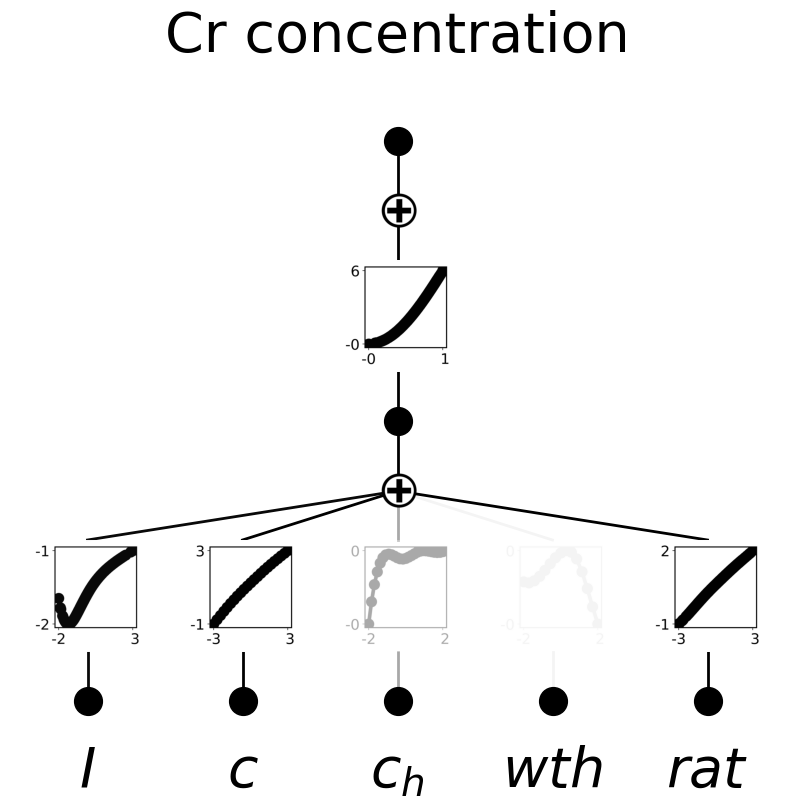

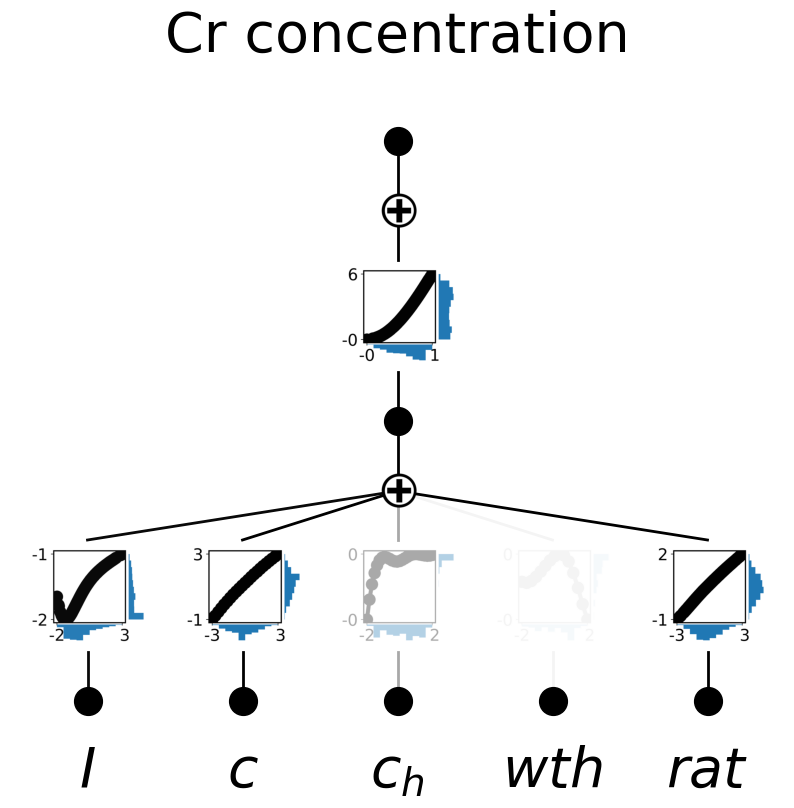

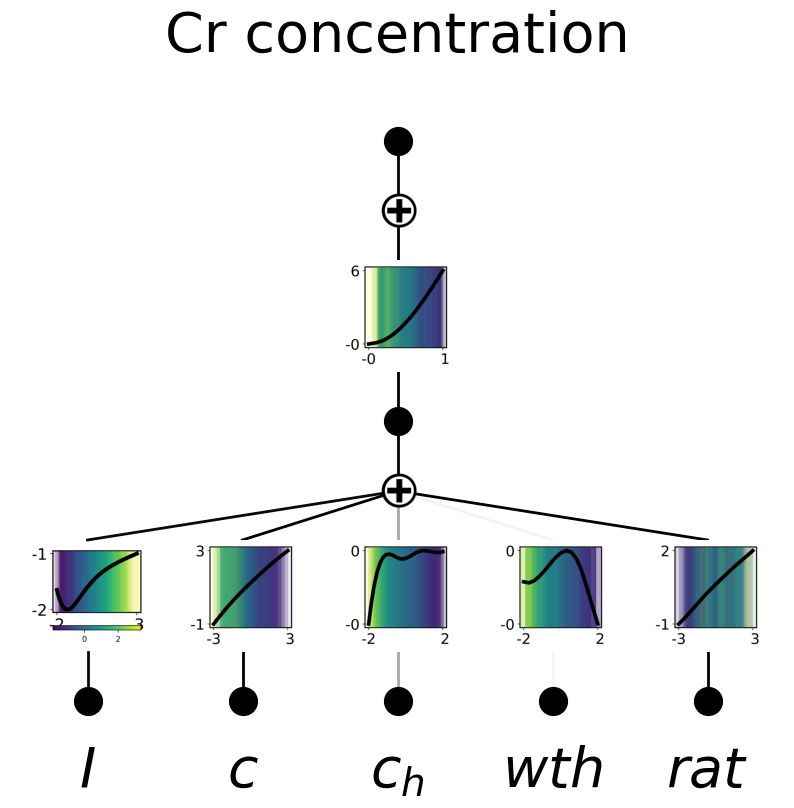

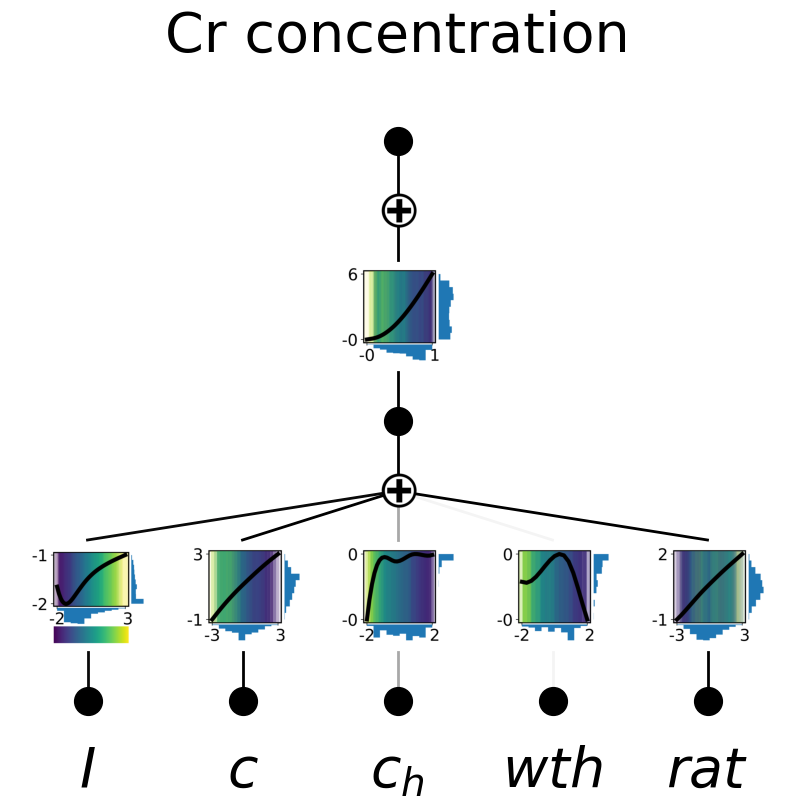

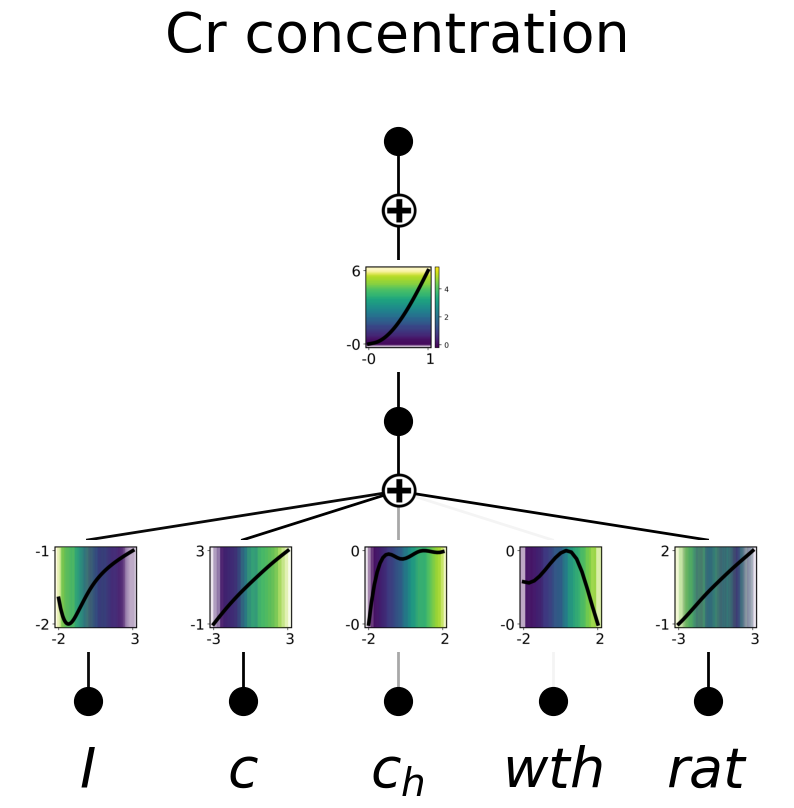

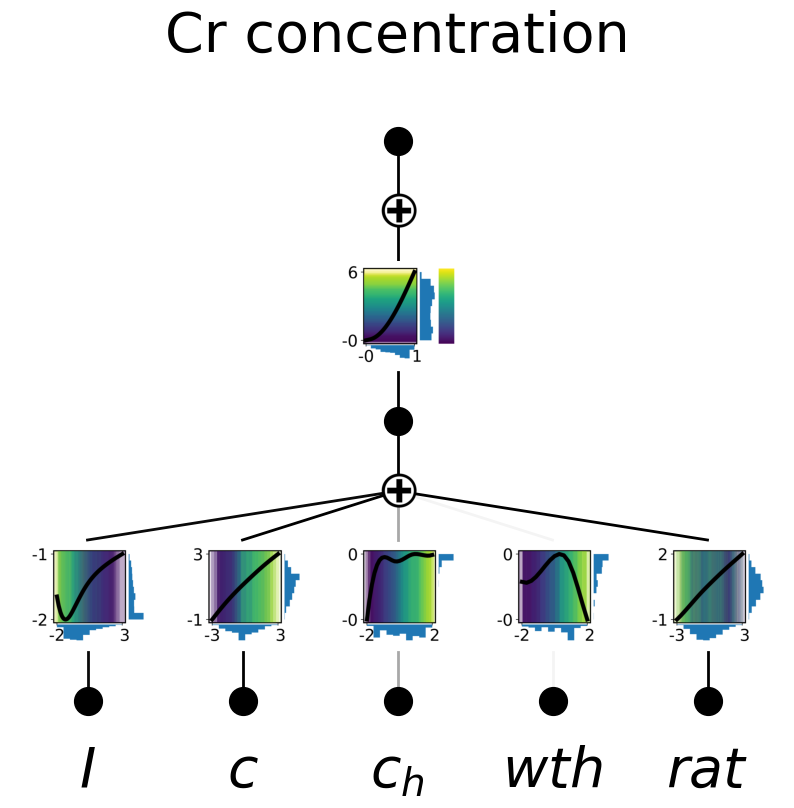

In [4]:
seed=1

model2 = KANRegressor(hidden_layer_sizes=[1], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)

result2 = model2.fit(x_train, y_train)

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']

model2.predict(x_train)

prnt_kwrgs = {'in_vars': VAR, 
              'out_vars': [PREDICT_IONS[0] + ' concentration'], 
              'tick': True,
              'title': None,
              'sample': True,
              'scale': 1,
              'scale_scatter': 0.7}

model2.kan.plot(**prnt_kwrgs, reper_in_out=np.nan, reper_index=np.nan, hist_plot=False)
model2.kan.plot(**prnt_kwrgs, reper_in_out=np.nan, reper_index=np.nan, hist_plot=True)

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=False)
model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)

model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=False)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)

plt.show()

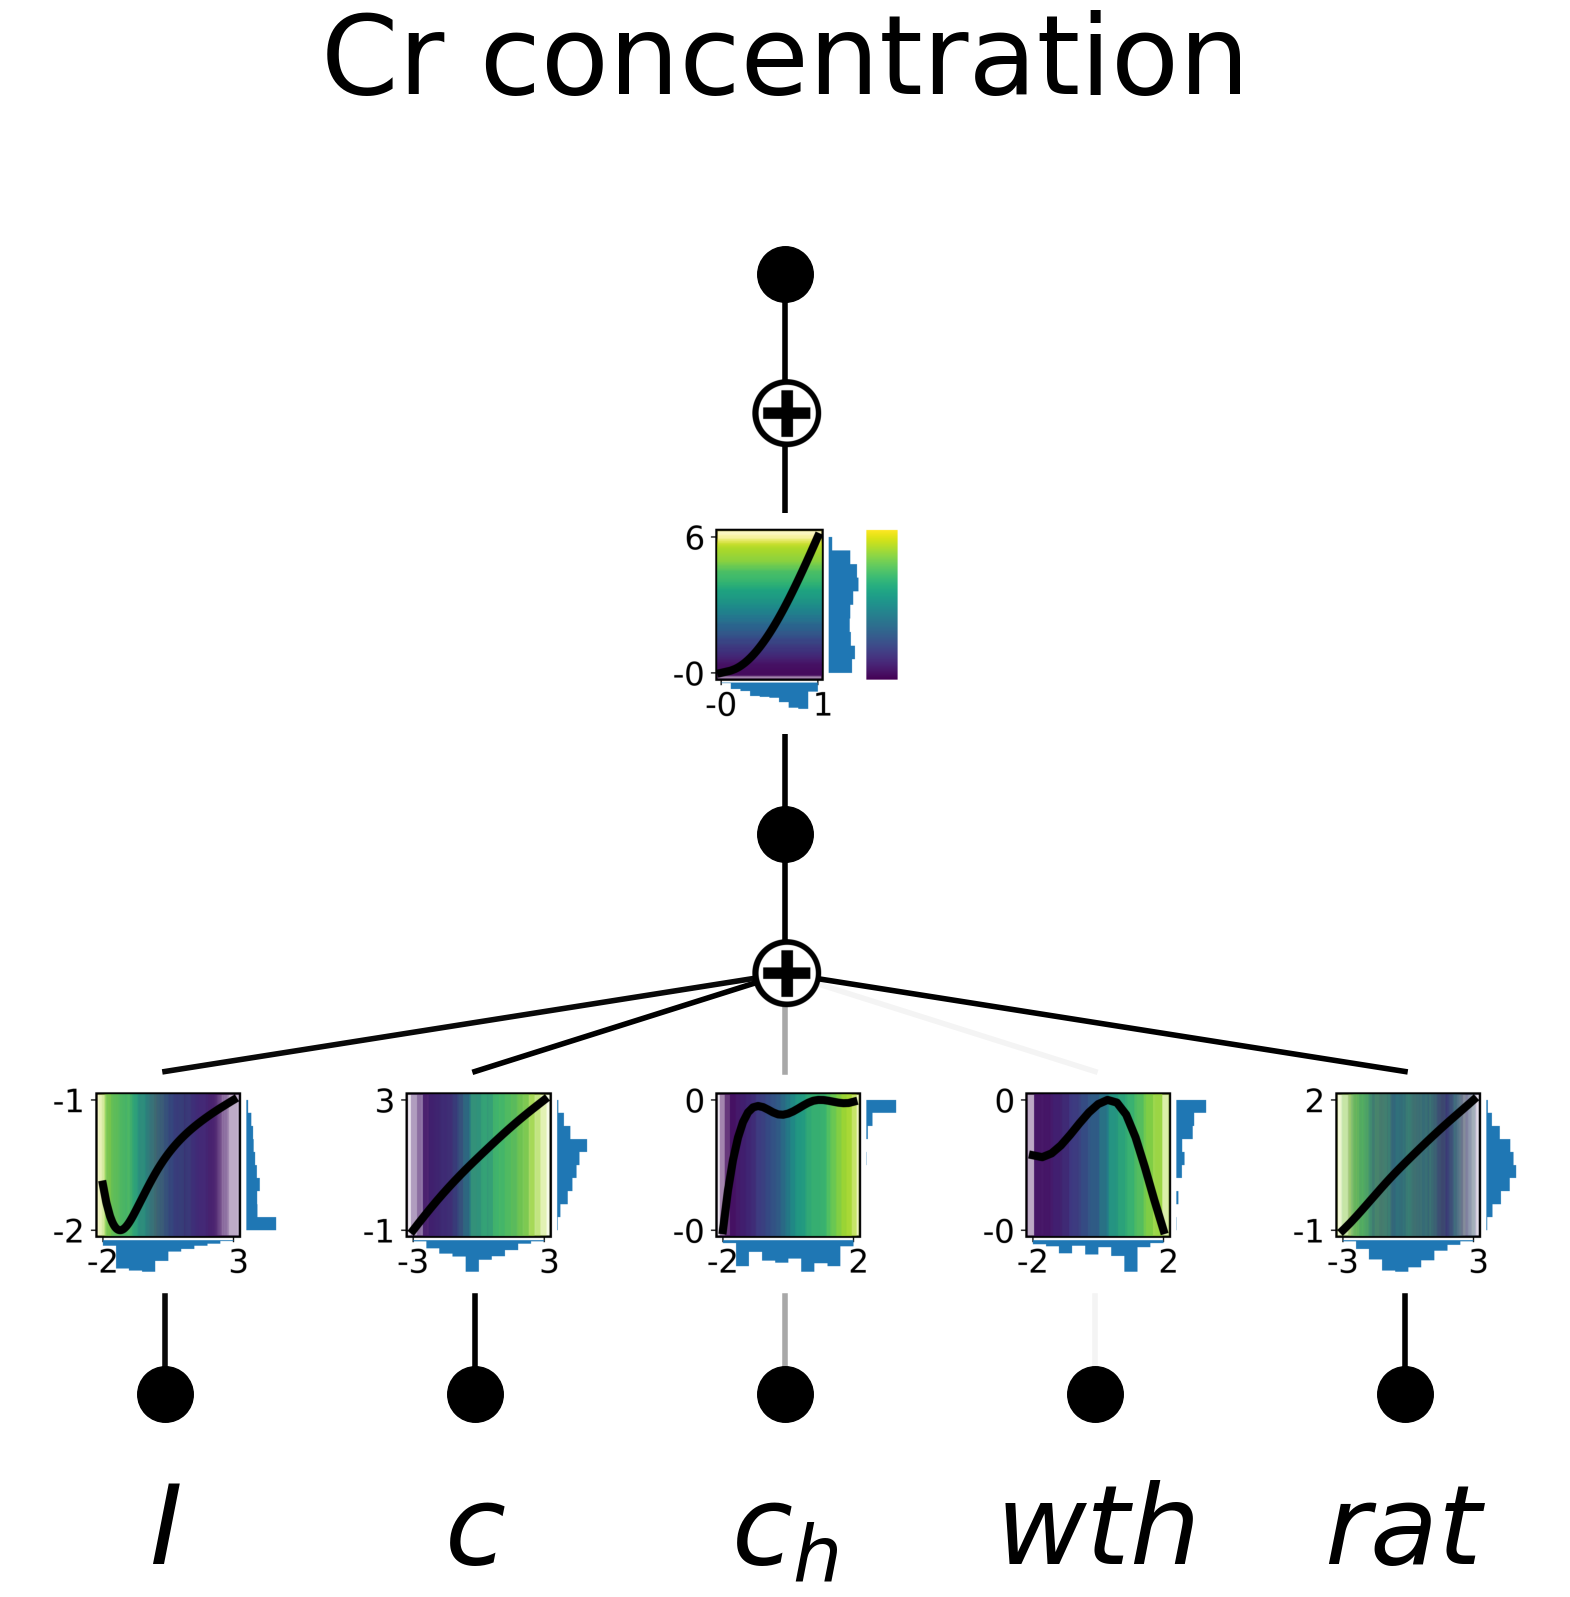

In [5]:
prnt_kwrgs = {'in_vars': VAR, 
              'tick': True,
              'out_vars': [PREDICT_IONS[0] + ' concentration'], 
              'title': None,
              'sample': True,
              'scale': 2,
              'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.31e-01 | tst_loss: 3.63e-01 | e_stop: 10/10 | reg: 9.33e+00 | :  13%|▏| 13/100 [00:03<


Early stopping criteria raised
saving model version 0.1


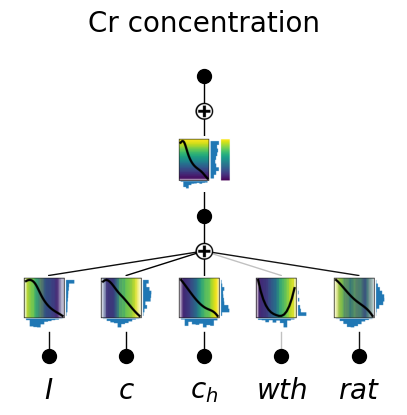

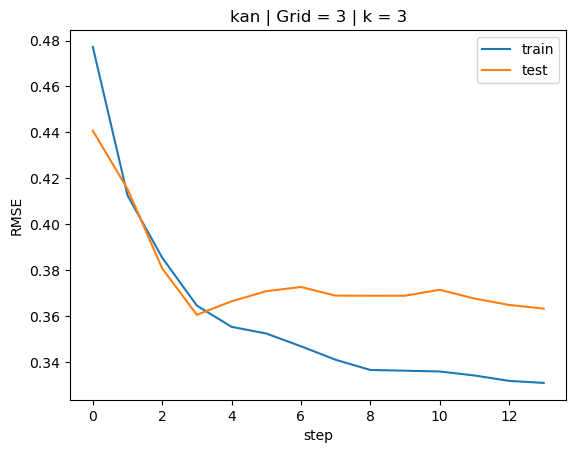

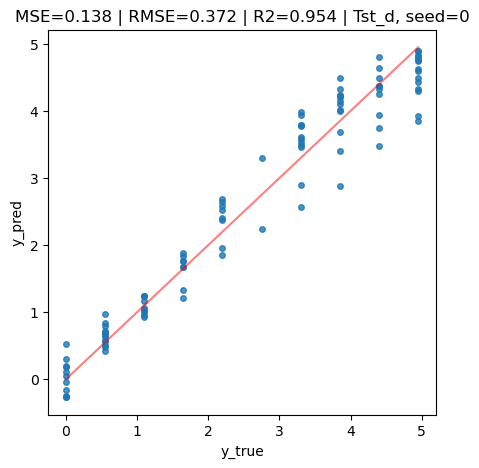

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.33e-01 | tst_loss: 3.62e-01 | e_stop: 10/10 | reg: 9.31e+00 | :  32%|▎| 32/100 [00:07<


Early stopping criteria raised
saving model version 0.1


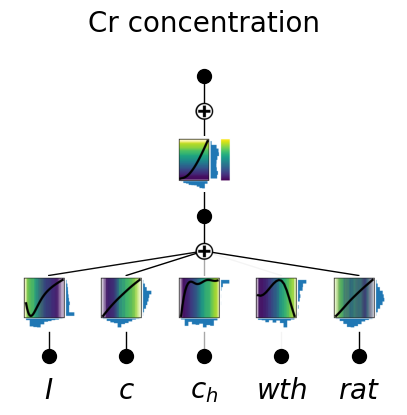

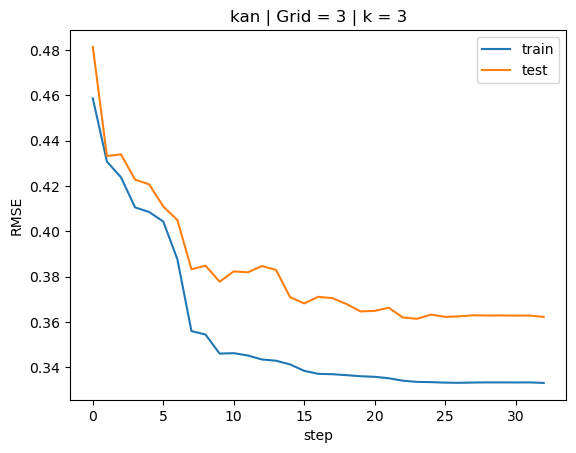

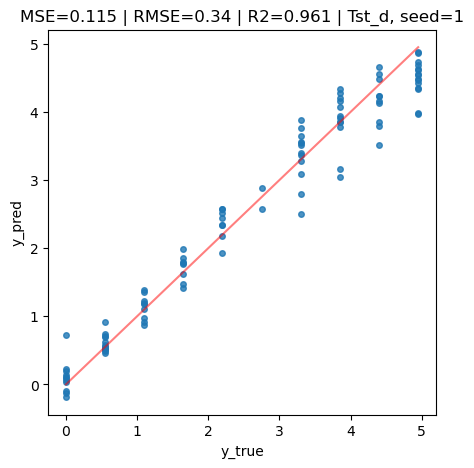

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 4.05e-01 | tst_loss: 4.50e-01 | e_stop: 10/10 | reg: 7.32e+00 | :  10%| | 10/100 [00:02<


Early stopping criteria raised
saving model version 0.1


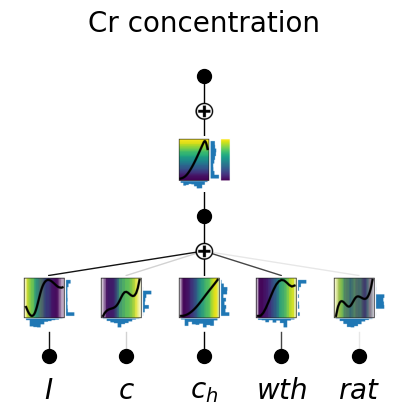

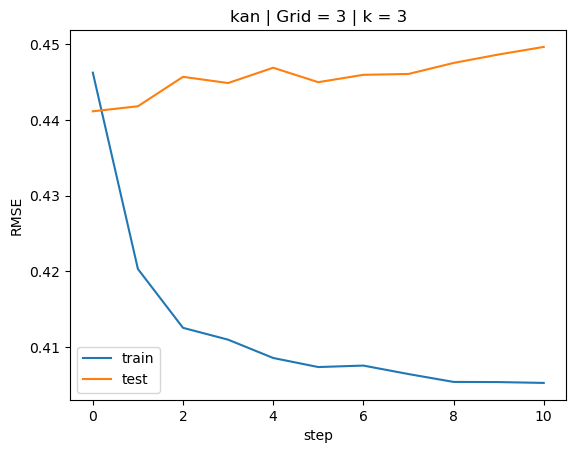

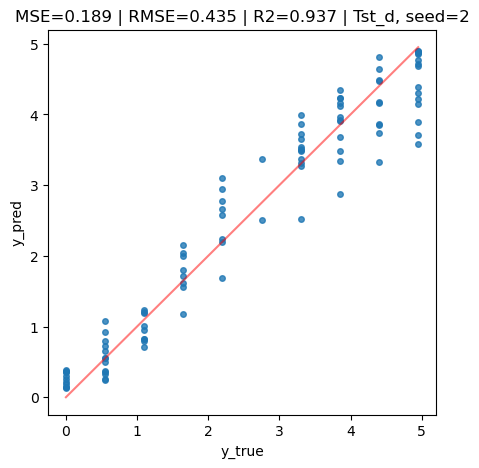

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.42e-01 | tst_loss: 2.67e-01 | e_stop: 10/10 | reg: 9.16e+00 | :  34%|▎| 34/100 [00:07<


Early stopping criteria raised
saving model version 0.1


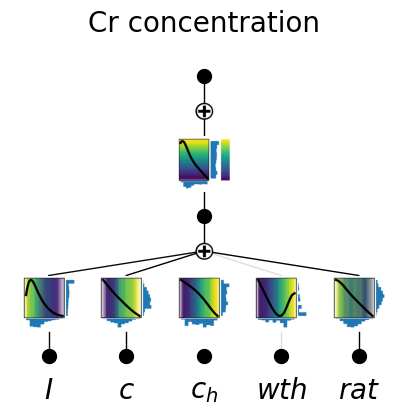

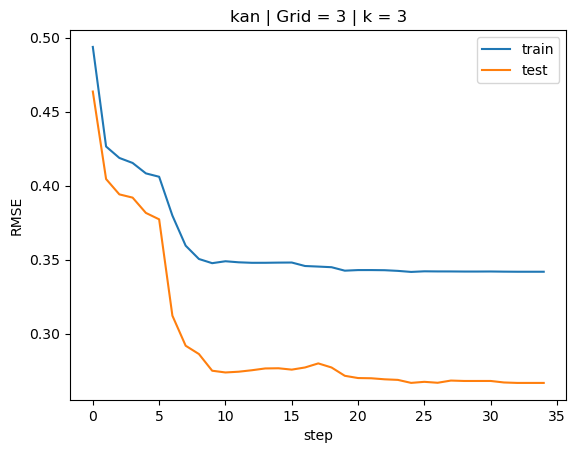

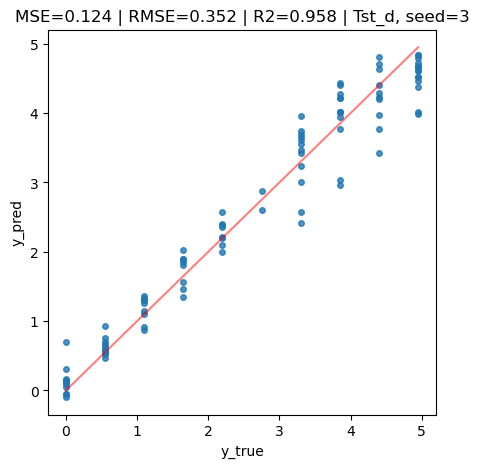

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.38e-01 | tst_loss: 3.03e-01 | e_stop: 10/10 | reg: 9.78e+00 | :  37%|▎| 37/100 [00:08<


Early stopping criteria raised
saving model version 0.1


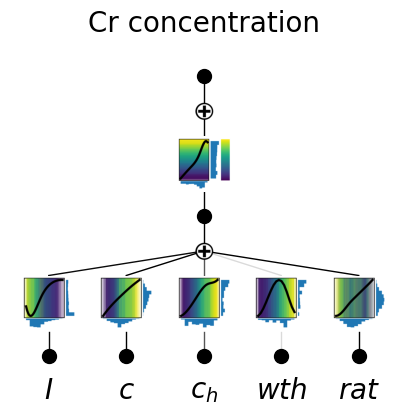

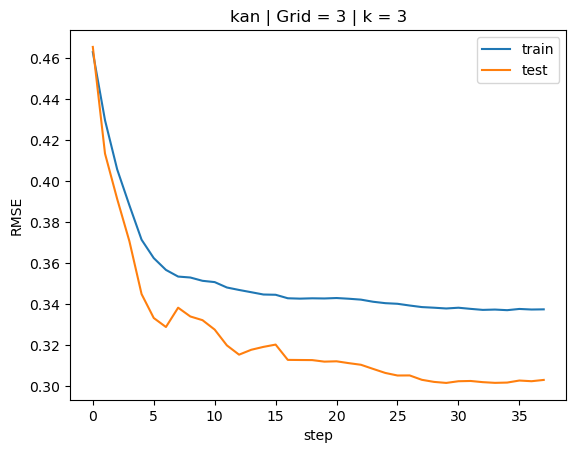

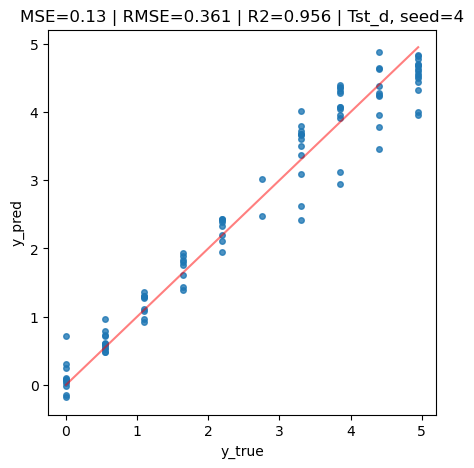

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 4.05e-01 | tst_loss: 4.04e-01 | e_stop: 10/10 | reg: 7.67e+00 | :  25%|▎| 25/100 [00:06<


Early stopping criteria raised
saving model version 0.1


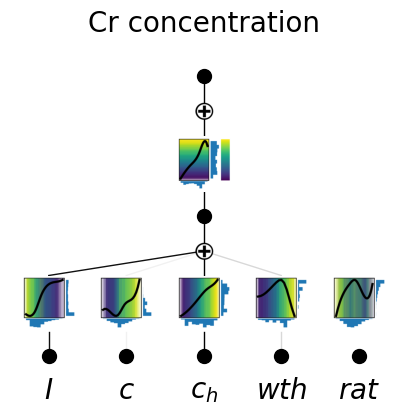

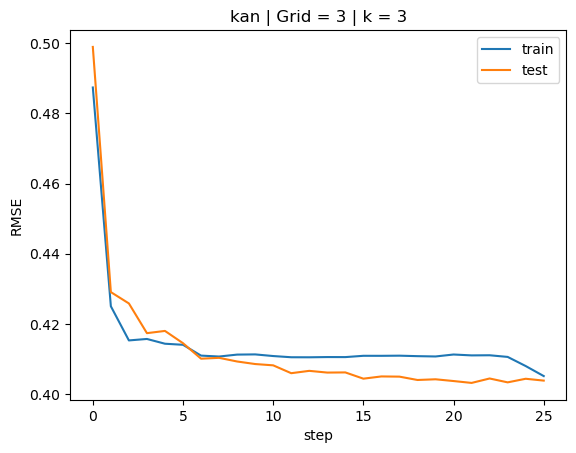

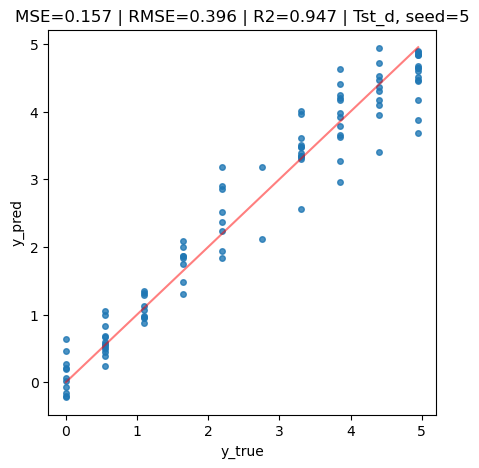

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.24e-01 | tst_loss: 3.81e-01 | e_stop: 10/10 | reg: 9.43e+00 | :  23%|▏| 23/100 [00:05<


Early stopping criteria raised
saving model version 0.1


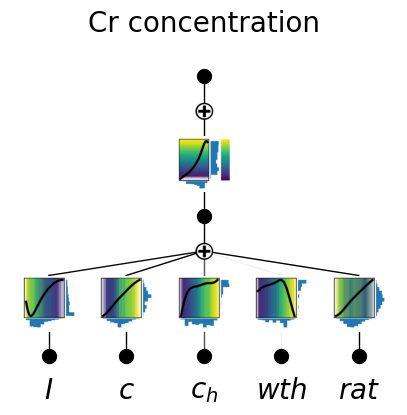

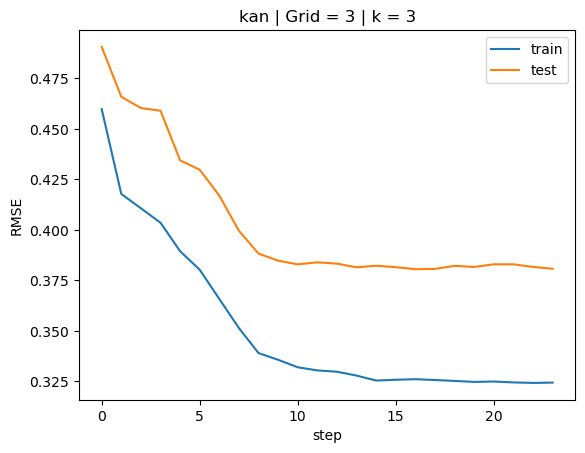

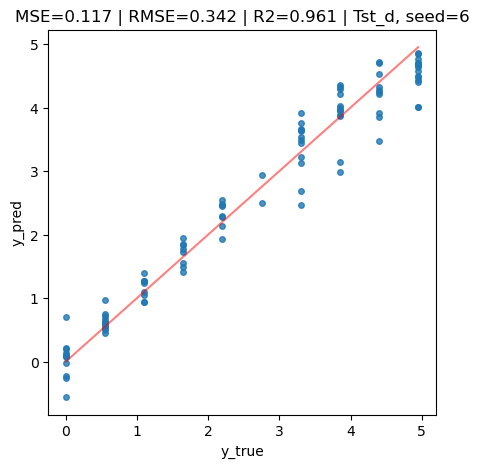

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.39e-01 | tst_loss: 3.26e-01 | e_stop: 10/10 | reg: 9.20e+00 | :  17%|▏| 17/100 [00:04<


Early stopping criteria raised
saving model version 0.1


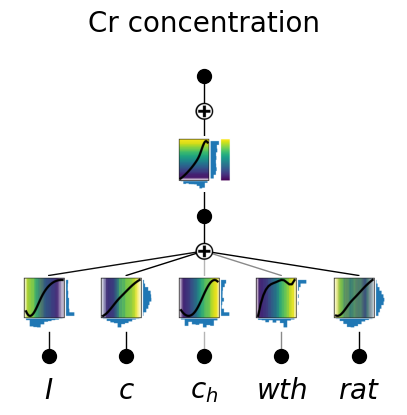

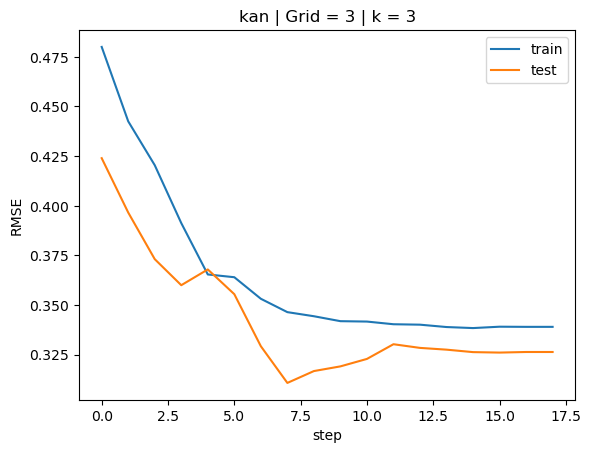

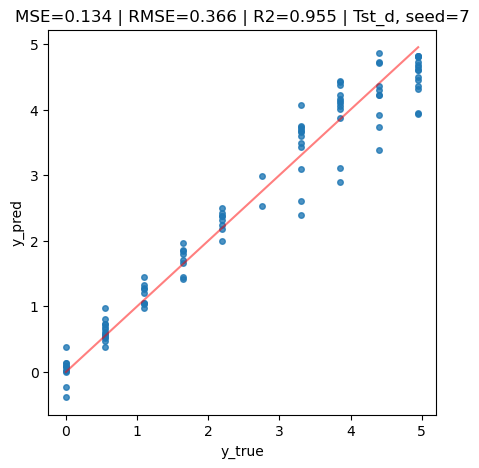

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.29e-01 | tst_loss: 3.40e-01 | e_stop: 10/10 | reg: 9.26e+00 | :  26%|▎| 26/100 [00:06<


Early stopping criteria raised
saving model version 0.1


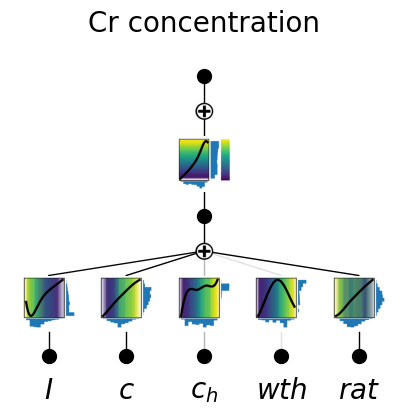

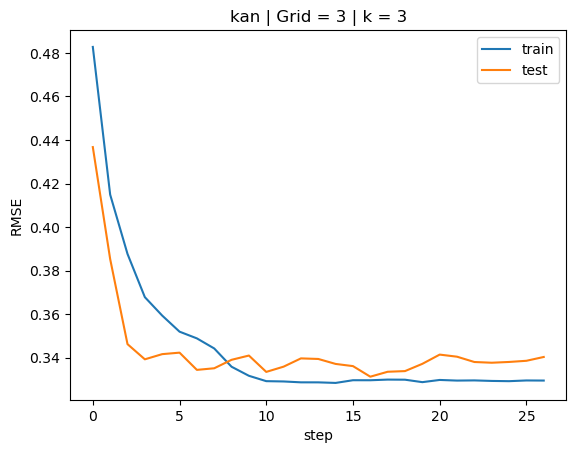

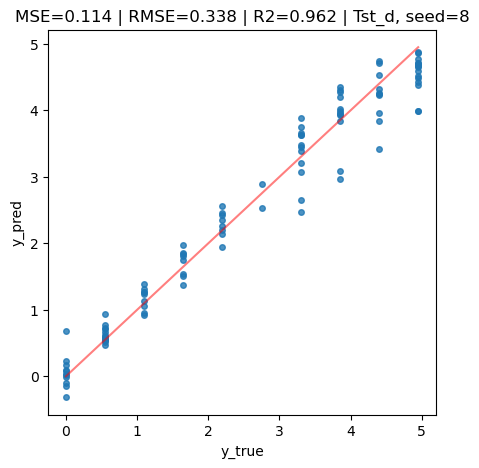

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.30e-01 | tst_loss: 3.64e-01 | e_stop: 10/10 | reg: 9.10e+00 | :  22%|▏| 22/100 [00:05<


Early stopping criteria raised
saving model version 0.1


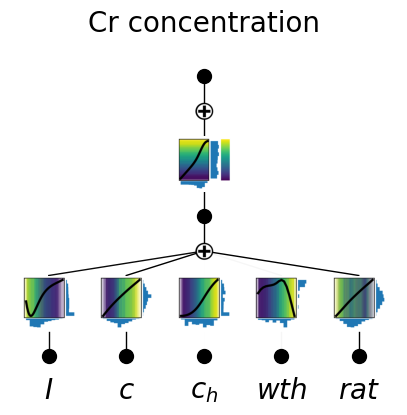

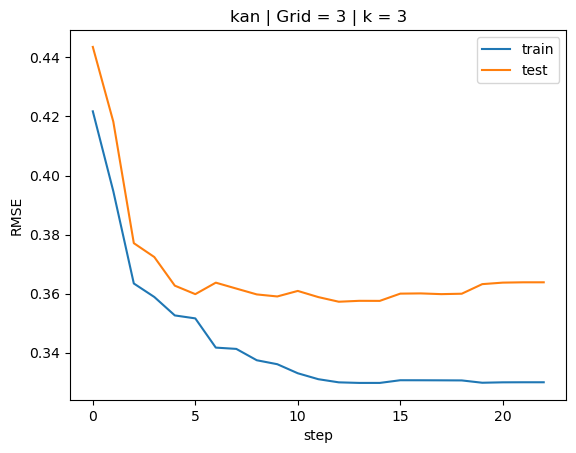

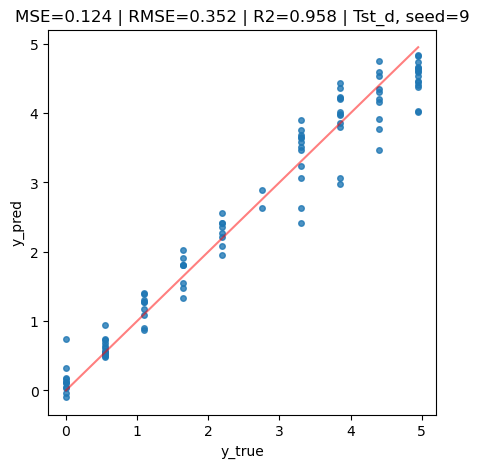

In [6]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| trn_loss: 3.33e-01 | tst_loss: 3.62e-01 | e_stop: 10/10 | reg: 9.31e+00 | :  32%|▎| 32/100 [00:08<


Early stopping criteria raised
saving model version 0.1


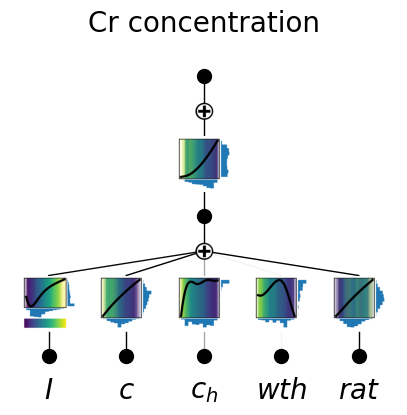

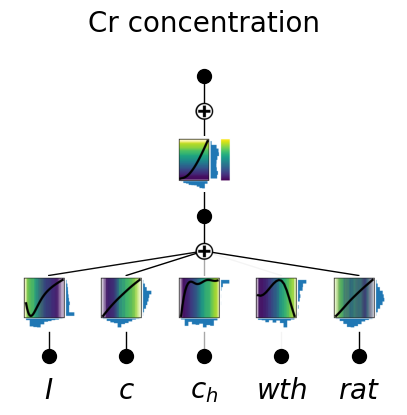

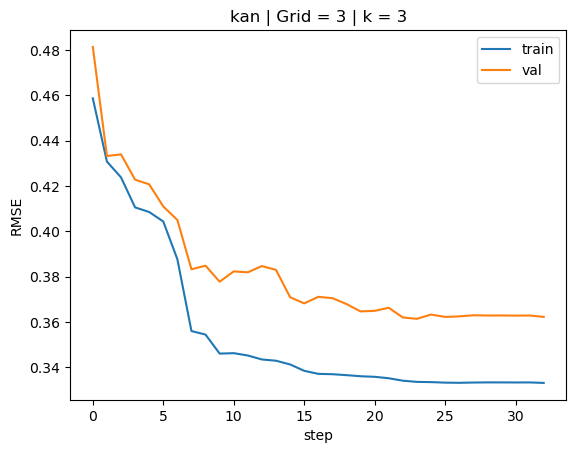

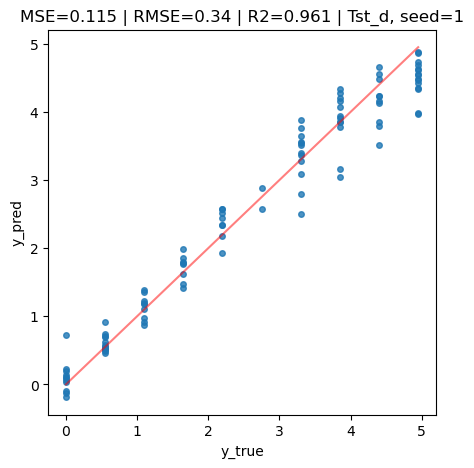

(0.11533622719781825, 0.9612429063872266)

In [7]:
grid = 3
k = 3

# Choose seed and train again
seed = 1
print(f'==========\n- {seed=} -\n==========')
model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

In [8]:
# suggest activation function
l = 0#1
i = 2#0
j = 0#0

inputs = model2.kan.spline_preacts[l][:,j,i]
outputs = model2.kan.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
#plt.plot(inputs, outputs, marker="o")

model2.kan.suggest_symbolic(l,i,j)

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.372691 -0.672729           1                1    0.665454
2      exp    0.944623 -4.174299           2                2    0.765140
3    1/x^2    0.931856 -3.875056           2                2    0.824989
4      1/x    0.911169 -3.492636           2                2    0.901473


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

In [9]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 2#0
j = 0#0

model2.kan.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2.predict(x_train)

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2


| trn_loss: 3.40e-01 | tst_loss: 3.58e-01 | e_stop: 10/10 | reg: 9.10e+00 | :  10%| | 10/100 [00:03<


Early stopping criteria raised
saving model version 0.3


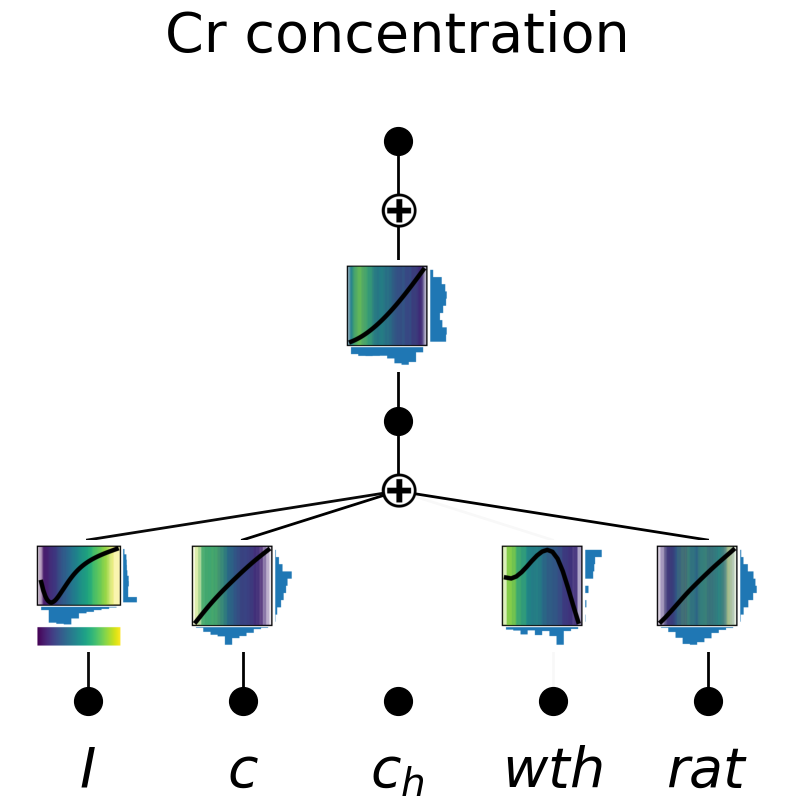

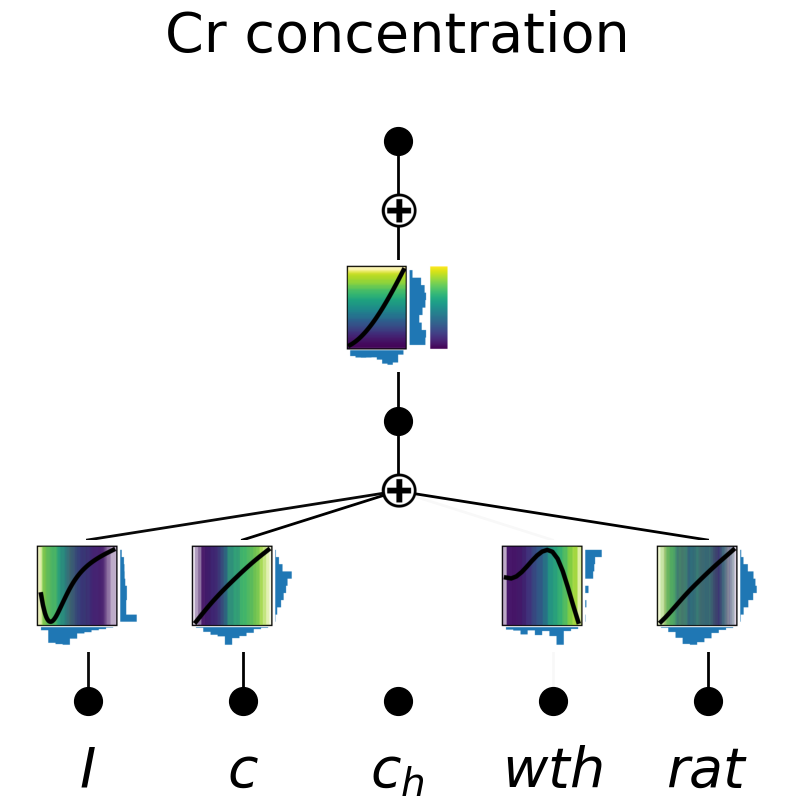

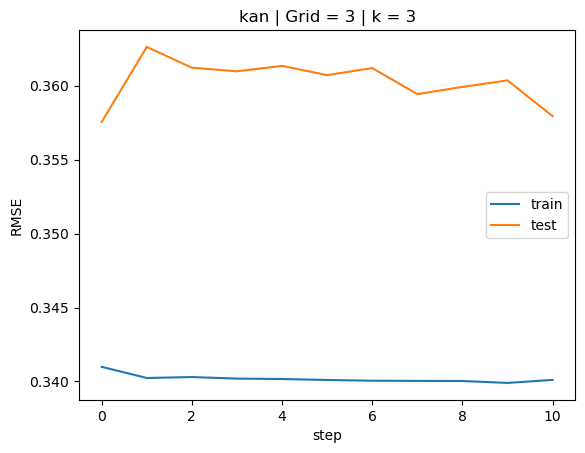

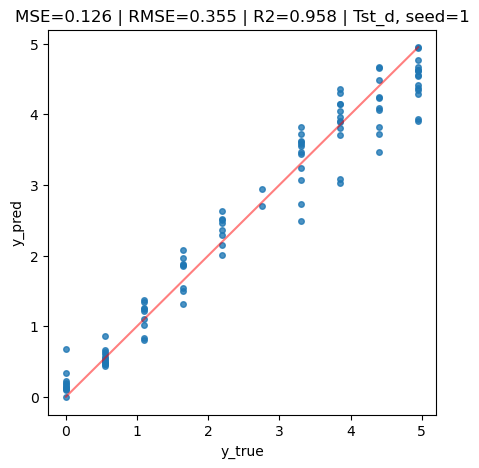

(0.1256873919575708, 0.9577645451529296)

In [10]:
# POSTFITTING reduced KAN
# Choose seed and train again
model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 1,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

# $Cu$

In [11]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Cu']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


#squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.15e-01 | tst_loss: 8.44e-01 | e_stop: 10/10 | reg: 8.35e+00 | :  11%| | 11/100 [00:02<


Early stopping criteria raised
saving model version 0.1


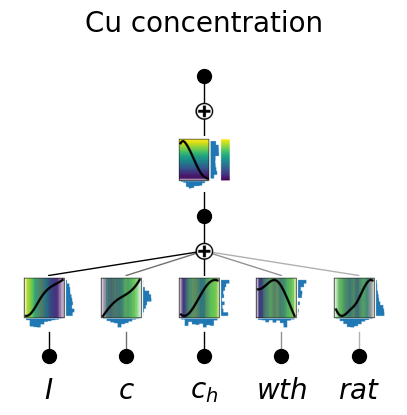

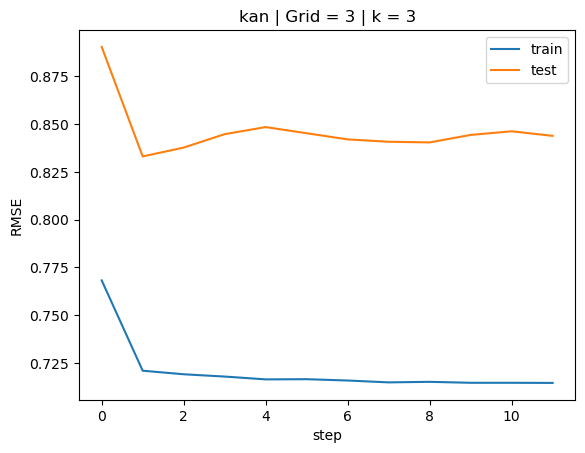

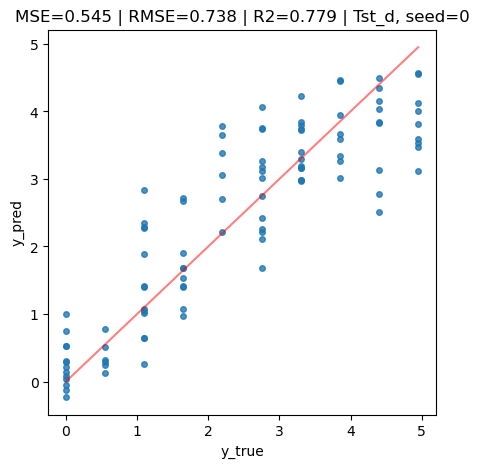

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.07e-01 | tst_loss: 7.63e-01 | e_stop: 10/10 | reg: 1.03e+01 | :  13%|▏| 13/100 [00:03<


Early stopping criteria raised
saving model version 0.1


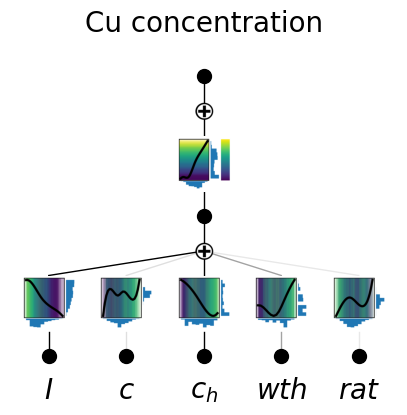

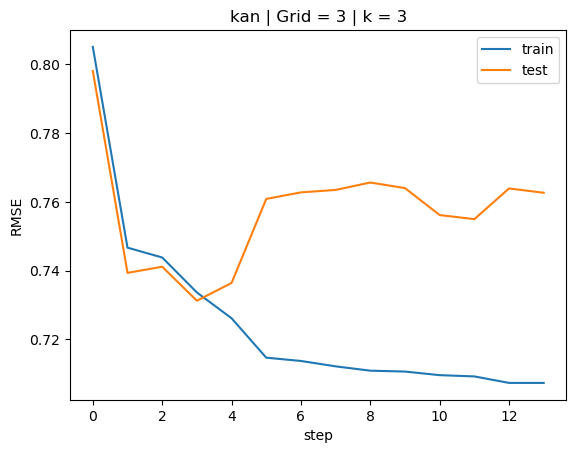

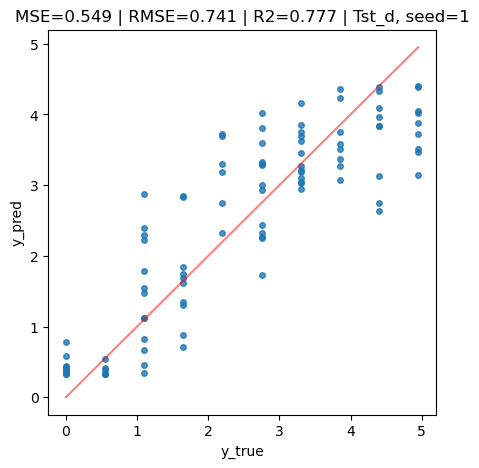

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.26e-01 | tst_loss: 7.37e-01 | e_stop: 10/10 | reg: 8.44e+00 | :  15%|▏| 15/100 [00:04<


Early stopping criteria raised
saving model version 0.1


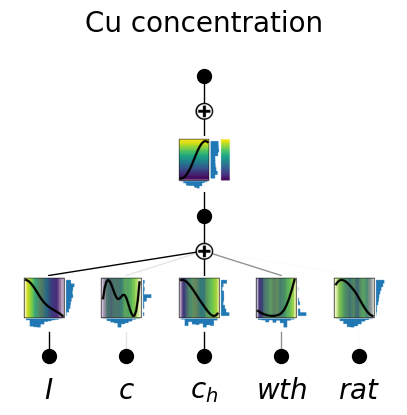

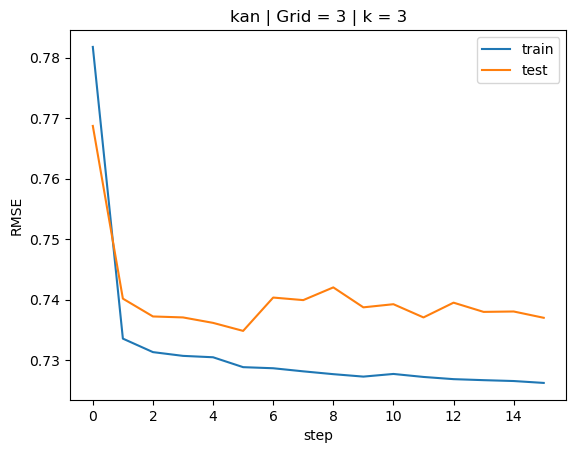

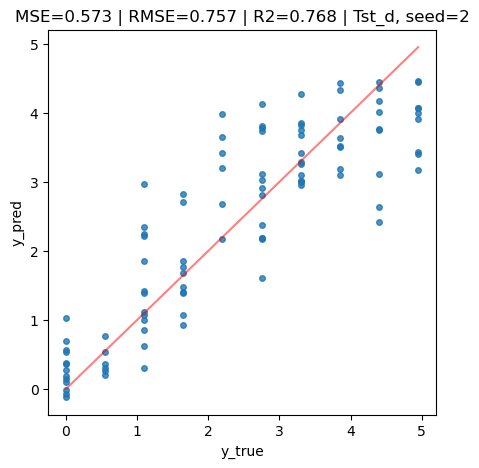

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.37e-01 | tst_loss: 6.52e-01 | e_stop: 10/10 | reg: 8.37e+00 | :  16%|▏| 16/100 [00:02<


Early stopping criteria raised
saving model version 0.1


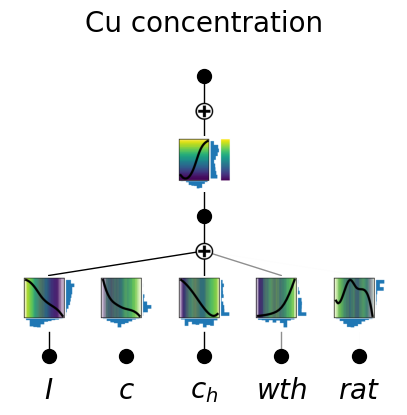

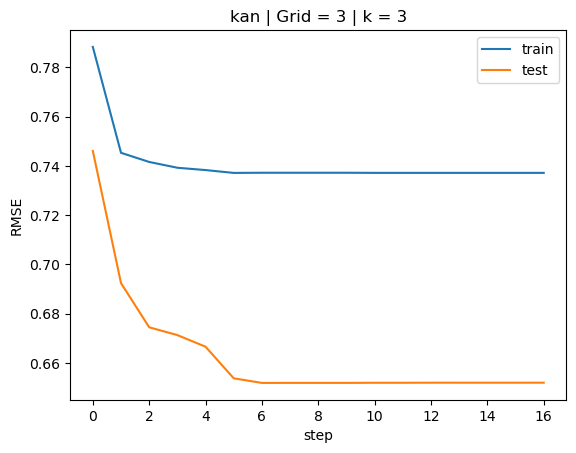

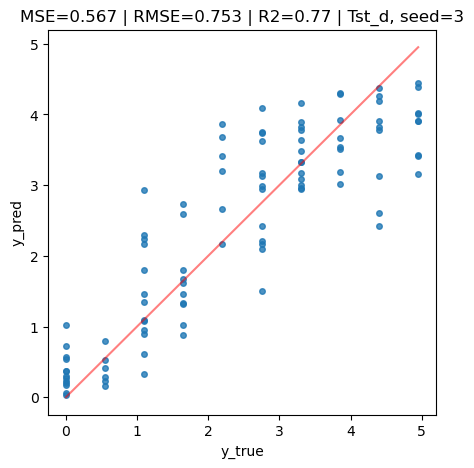

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.38e-01 | tst_loss: 6.30e-01 | e_stop: 10/10 | reg: 8.58e+00 | :  12%| | 12/100 [00:03<


Early stopping criteria raised
saving model version 0.1


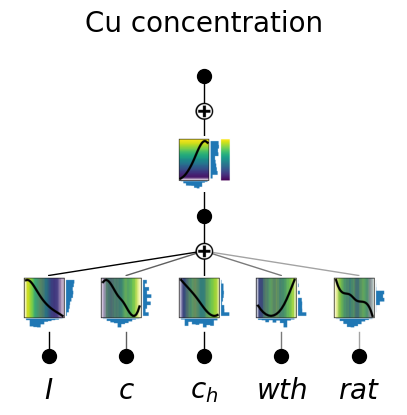

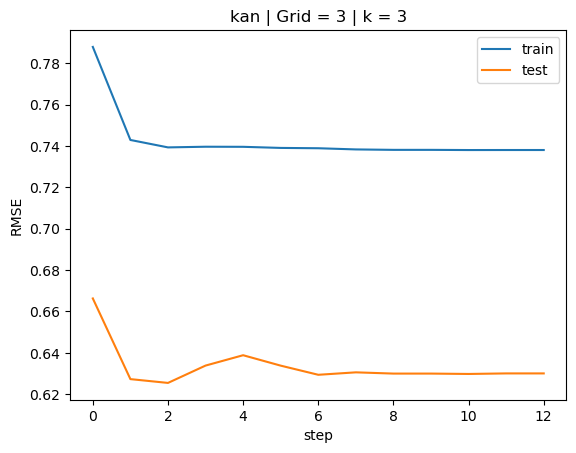

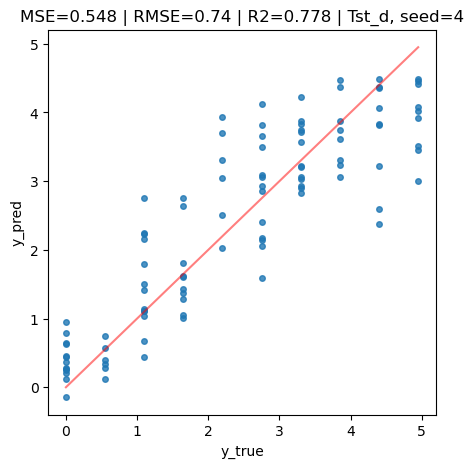

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.25e-01 | tst_loss: 7.65e-01 | e_stop: 10/10 | reg: 8.43e+00 | :  13%|▏| 13/100 [00:03<


Early stopping criteria raised
saving model version 0.1


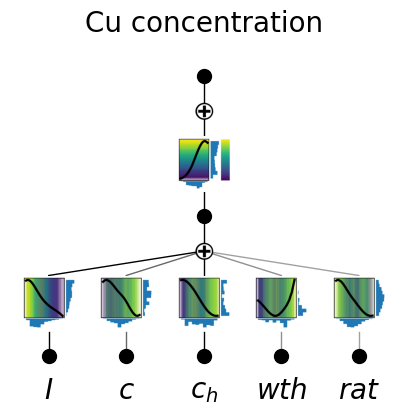

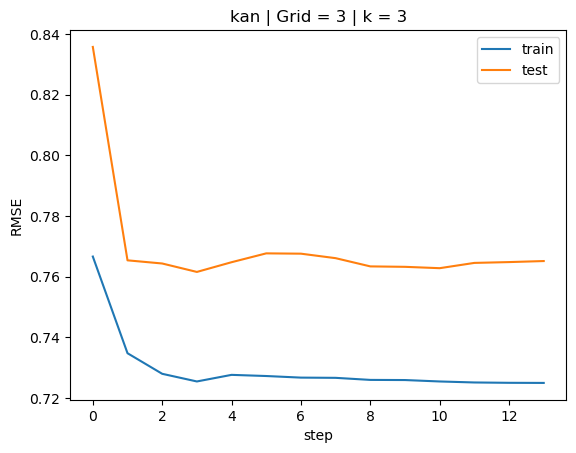

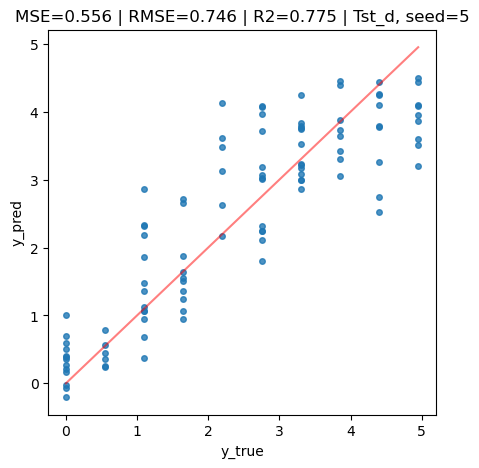

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.07e-01 | tst_loss: 8.91e-01 | e_stop: 10/10 | reg: 8.51e+00 | :  11%| | 11/100 [00:03<


Early stopping criteria raised
saving model version 0.1


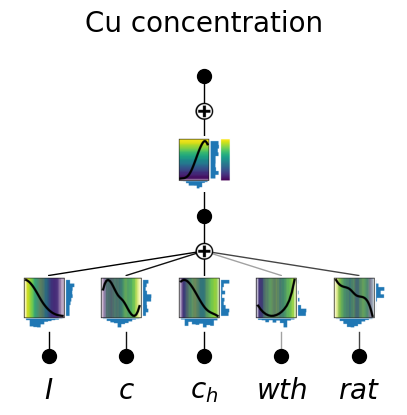

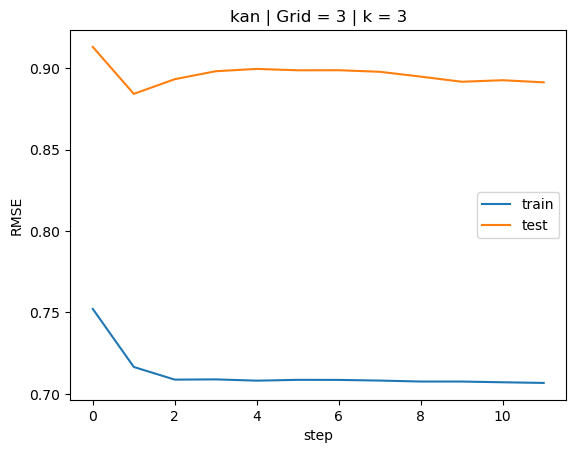

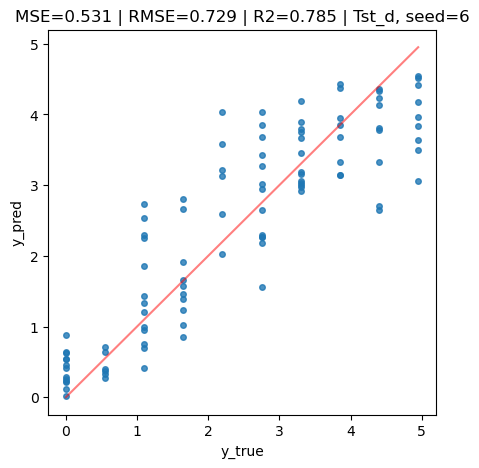

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.07e-01 | tst_loss: 7.65e-01 | e_stop: 10/10 | reg: 1.01e+01 | :  10%| | 10/100 [00:02<


Early stopping criteria raised
saving model version 0.1


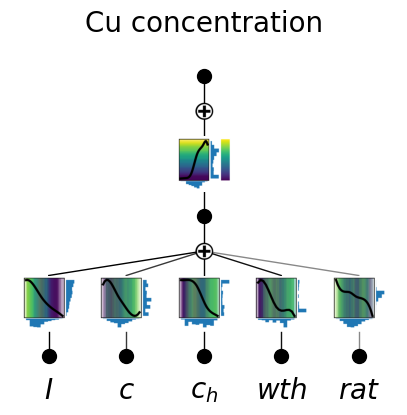

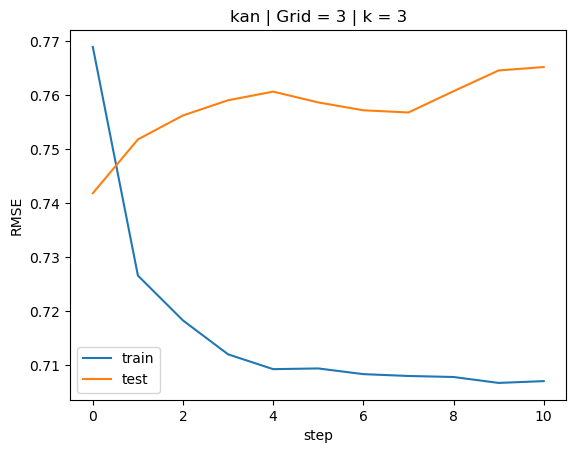

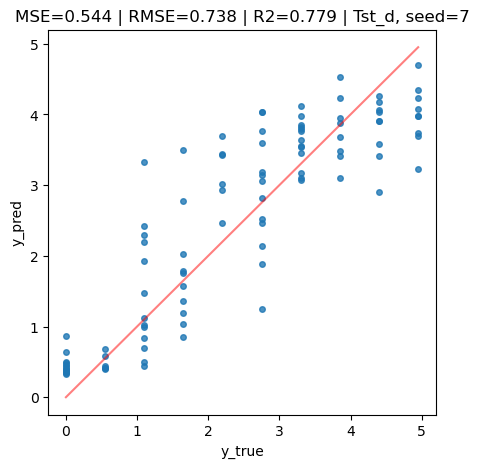

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.24e-01 | tst_loss: 6.19e-01 | e_stop: 10/10 | reg: 1.01e+01 | :  12%| | 12/100 [00:03<


Early stopping criteria raised
saving model version 0.1


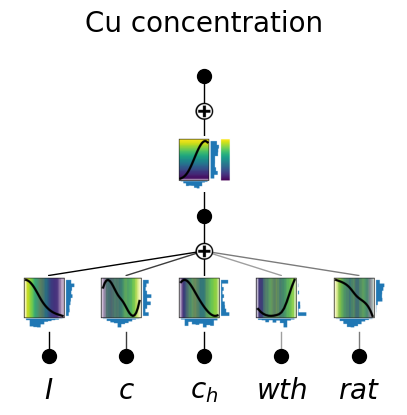

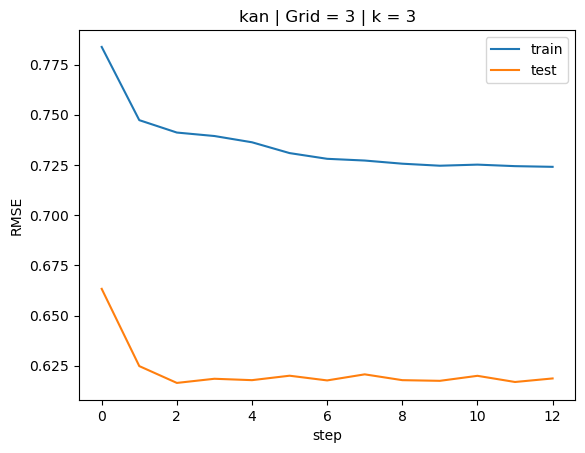

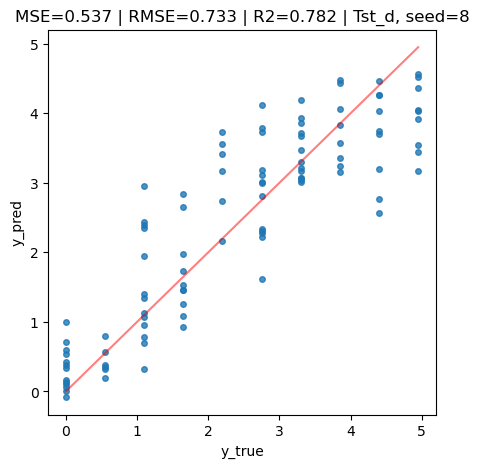

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.11e-01 | tst_loss: 7.29e-01 | e_stop: 10/10 | reg: 1.01e+01 | :  25%|▎| 25/100 [00:06<


Early stopping criteria raised
saving model version 0.1


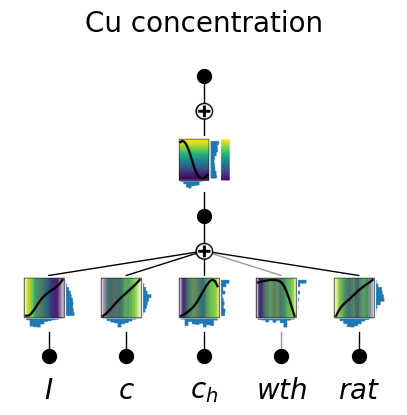

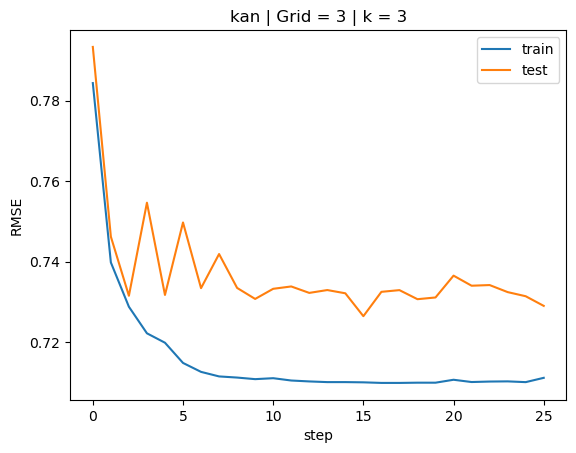

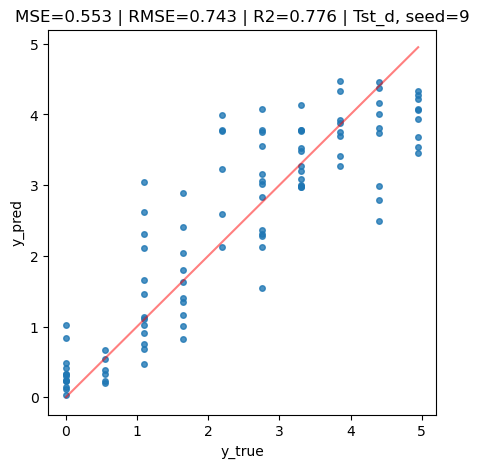

In [12]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=grid, k=k, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.37e-01 | tst_loss: 6.52e-01 | e_stop: 10/10 | reg: 8.37e+00 | :  16%|▏| 16/100 [00:03<


Early stopping criteria raised
saving model version 0.1


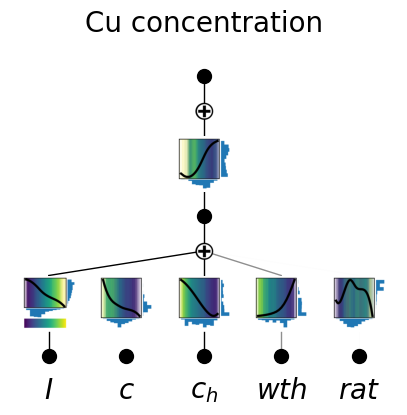

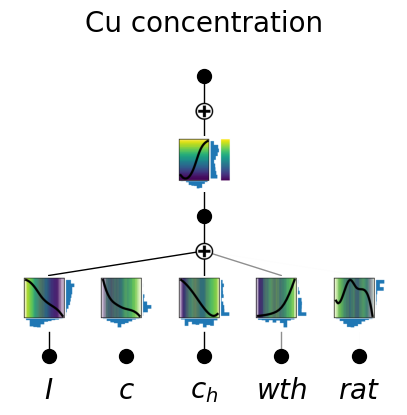

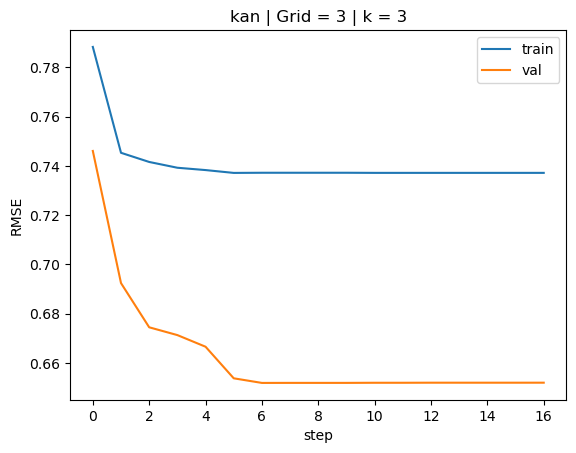

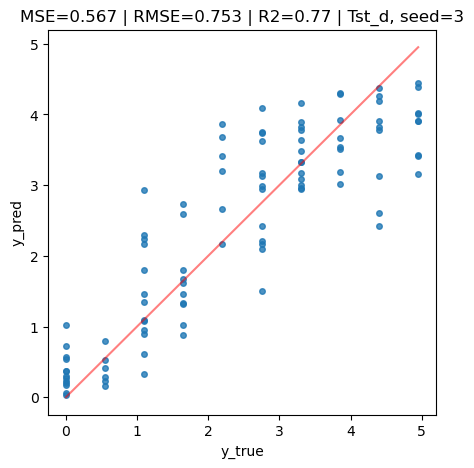

(0.5667527986784504, 0.7702728222524582)

In [13]:
# Choose seed and train again
seed = 3
print(f'==========\n- {seed=} -\n==========')
model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

In [14]:
# suggest activation function
l = 0#1
i = 4#0
j = 0#0

inputs = model2.kan.spline_preacts[l][:,j,i]
outputs = model2.kan.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
#plt.plot(inputs, outputs, marker="o")

model2.kan.suggest_symbolic(l,i,j)

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.061819 -0.092047           1                1    0.781591
2      cos    0.739132 -1.938554           2                2    1.212289
3      sin    0.739132 -1.938554           2                2    1.212289
4      x^2    0.662430 -1.566698           2                2    1.286660


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

In [15]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 1#0
j = 0#0

model2.kan.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2.predict(x_train)

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2


| trn_loss: 7.36e-01 | tst_loss: 6.49e-01 | e_stop: 10/10 | reg: 8.34e+00 | :  15%|▏| 15/100 [00:05<


Early stopping criteria raised
saving model version 0.3


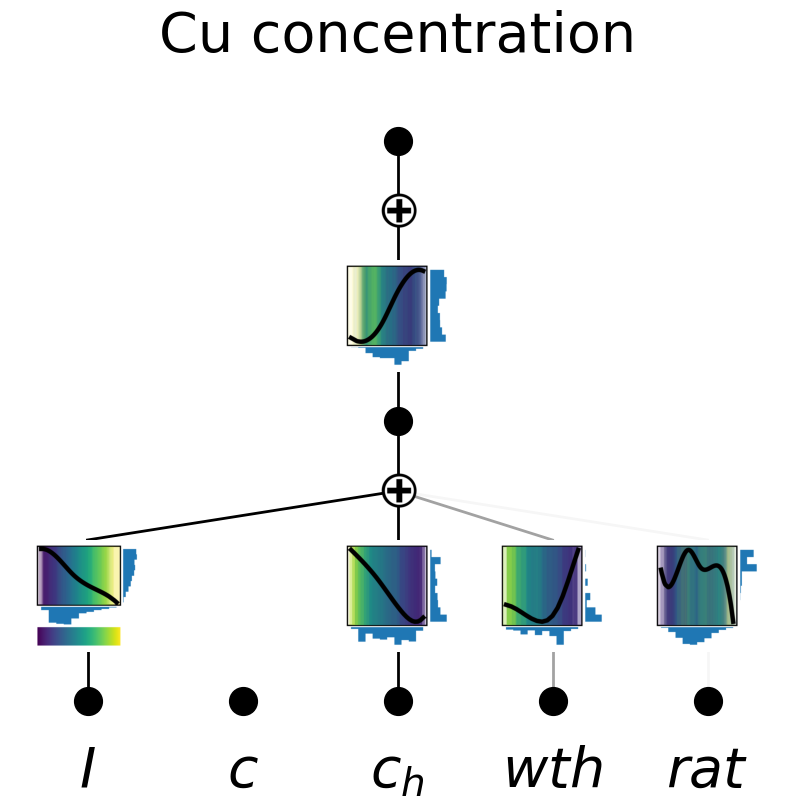

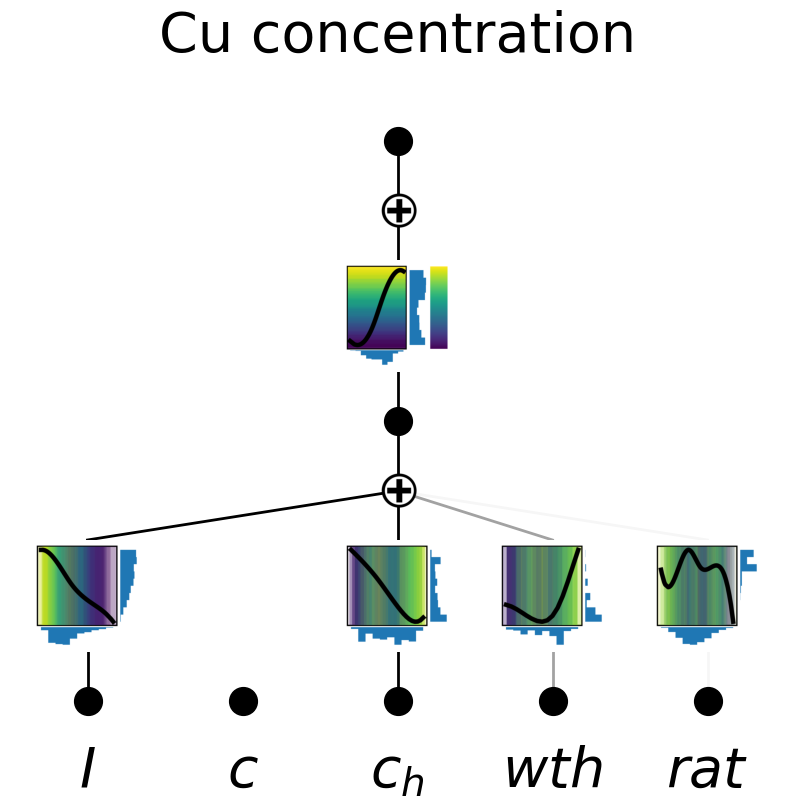

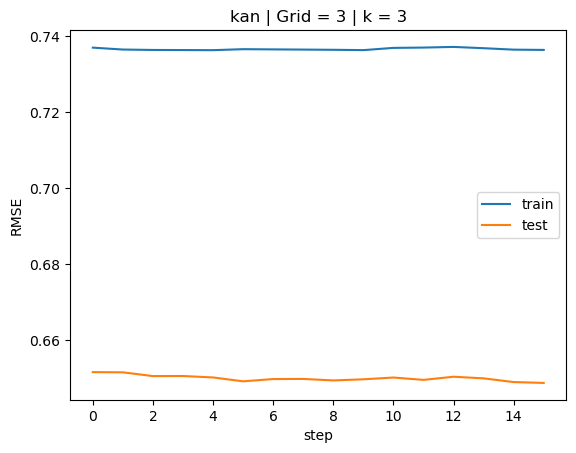

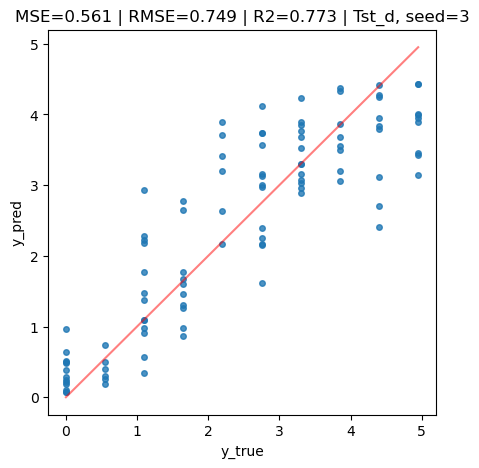

(0.56106822082961, 0.7725770050089358)

In [16]:
# POSTFITTING reduced KAN
# Choose seed and train again
model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 1,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

# $Ni$

In [17]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Ni']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


#squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| trn_loss: 1.49e+00 | tst_loss: 1.61e+00 | e_stop: 10/10 | reg: 8.50e+00 | :  15%|▏| 15/100 [00:04<


Early stopping criteria raised
saving model version 0.1


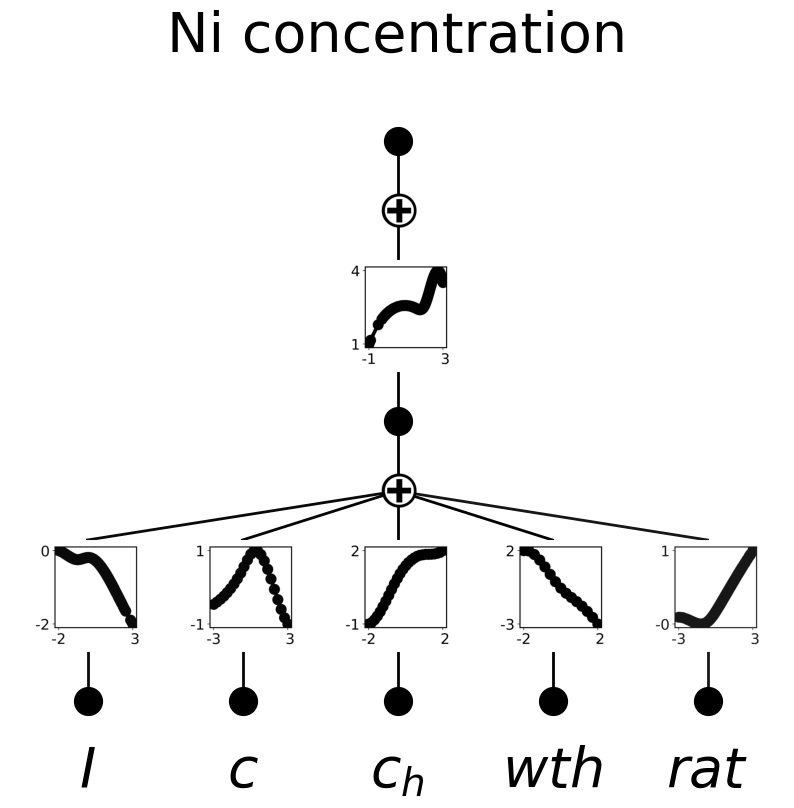

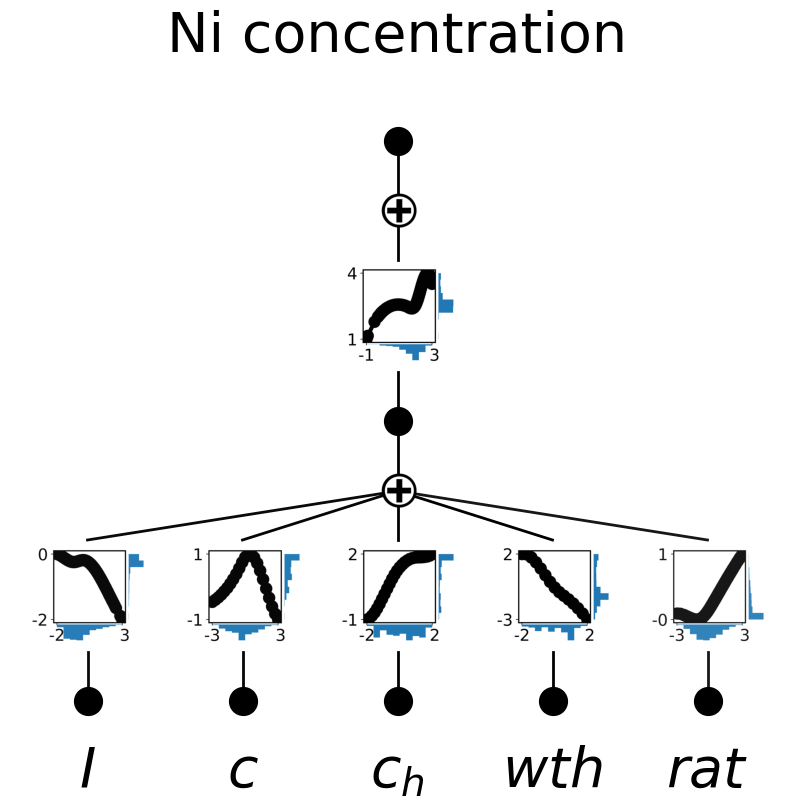

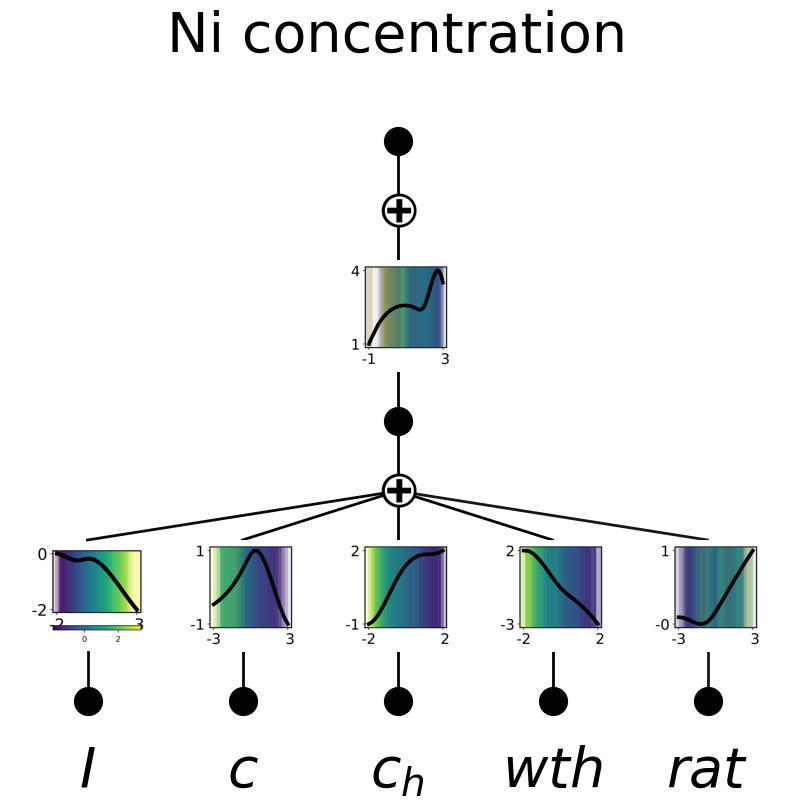

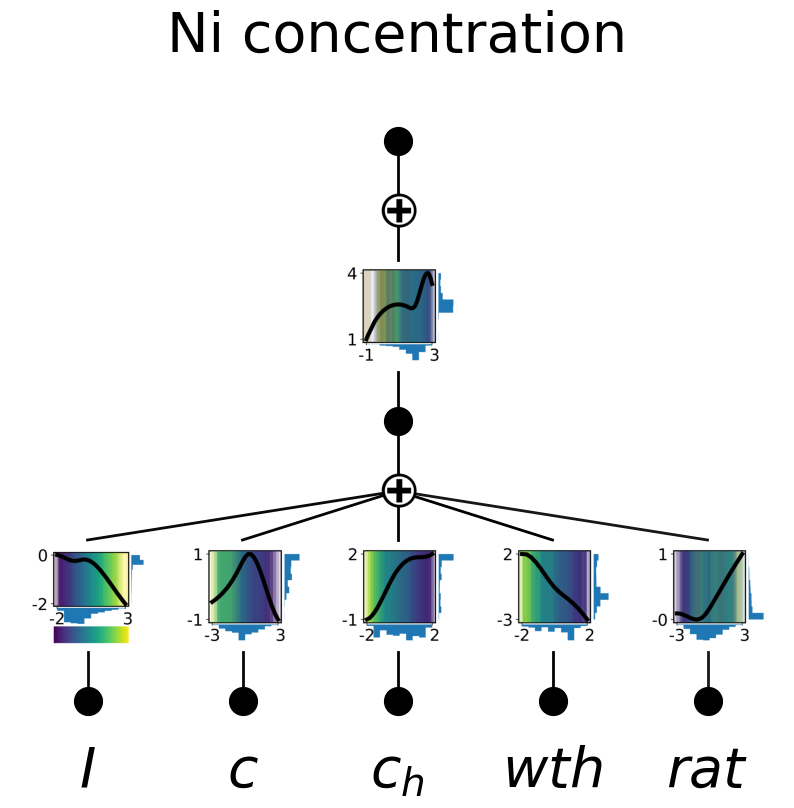

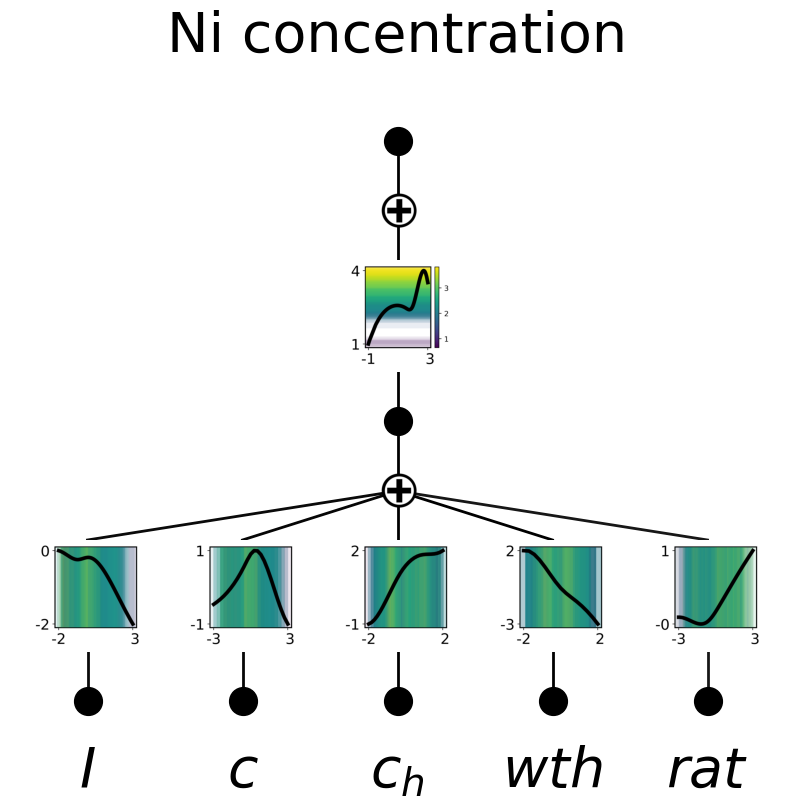

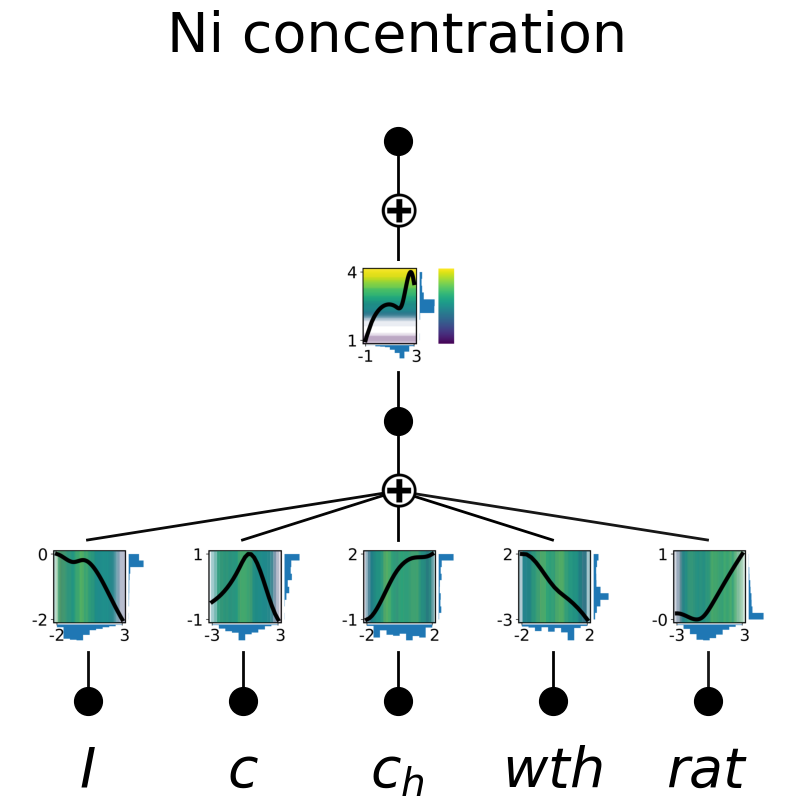

In [18]:
seed=1

model2 = KANRegressor(hidden_layer_sizes=[1], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)

result2 = model2.fit(x_train, y_train)

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']

model2.predict(x_train)

prnt_kwrgs = {'in_vars': VAR, 
              'out_vars': [PREDICT_IONS[0] + ' concentration'], 
              'tick': True,
              'title': None,
              'sample': True,
              'scale': 1,
              'scale_scatter': 0.7}

model2.kan.plot(**prnt_kwrgs, reper_in_out=np.nan, reper_index=np.nan, hist_plot=False)
model2.kan.plot(**prnt_kwrgs, reper_in_out=np.nan, reper_index=np.nan, hist_plot=True)

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=False)
model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)

model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=False)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)

plt.show()

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| trn_loss: 1.48e+00 | tst_loss: 1.52e+00 | e_stop: 10/10 | reg: 6.56e+00 | :  16%|▏| 16/100 [00:03<


Early stopping criteria raised
saving model version 0.1


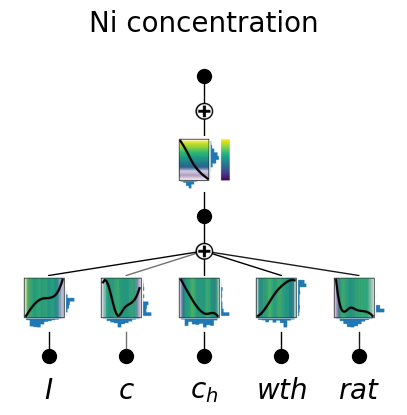

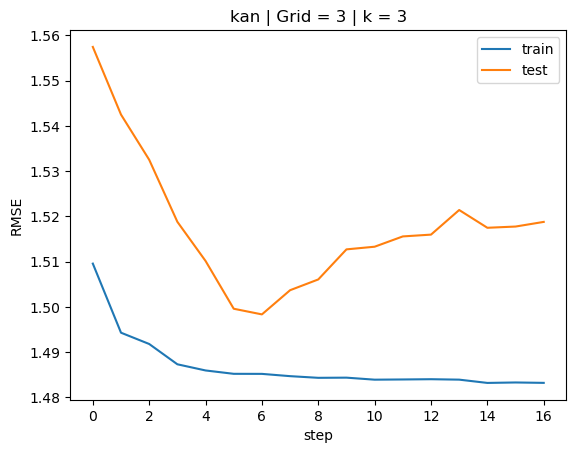

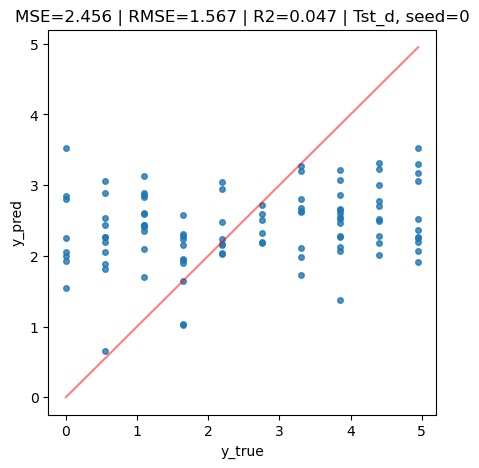

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.61e+00 | e_stop: 10/10 | reg: 8.50e+00 | :  15%|▏| 15/100 [00:03<


Early stopping criteria raised
saving model version 0.1


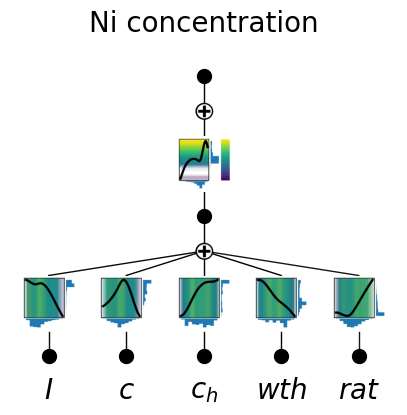

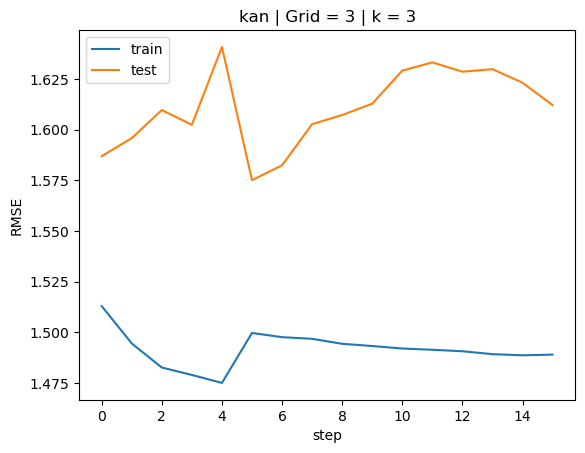

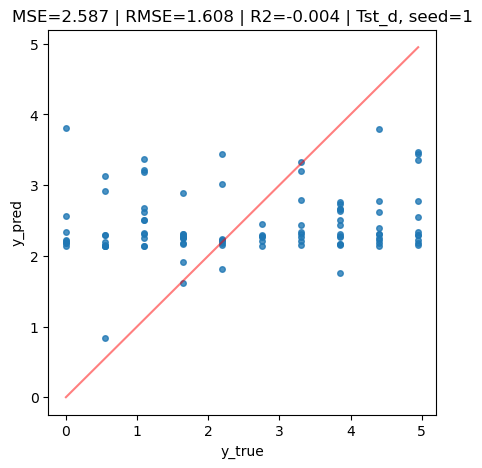

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.49e+00 | e_stop: 10/10 | reg: 7.20e+00 | :  11%| | 11/100 [00:03<


Early stopping criteria raised
saving model version 0.1


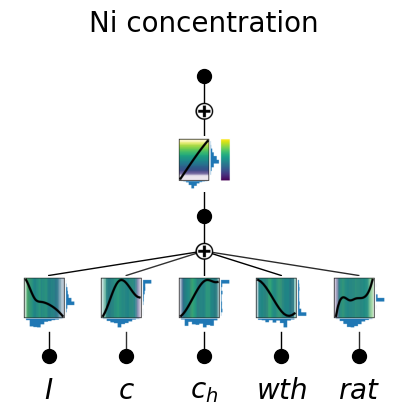

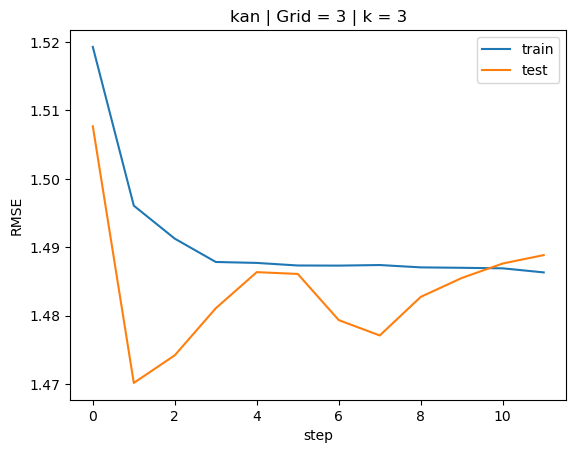

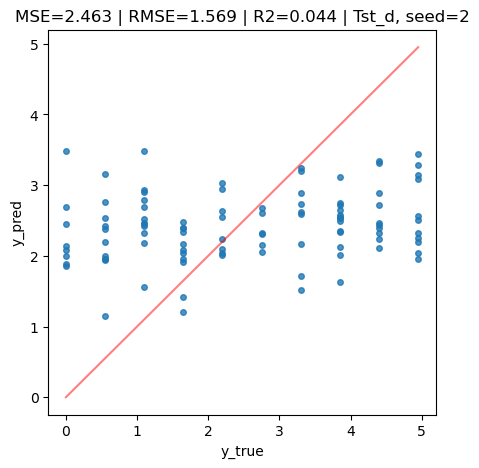

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.48e+00 | e_stop: 10/10 | reg: 7.43e+00 | :  13%|▏| 13/100 [00:03<


Early stopping criteria raised
saving model version 0.1


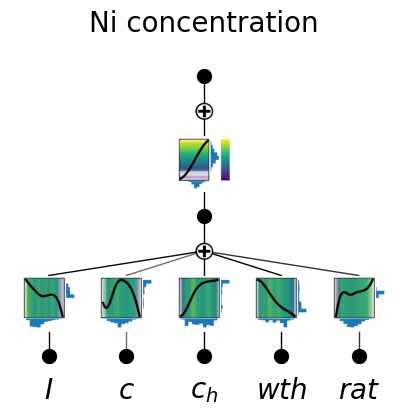

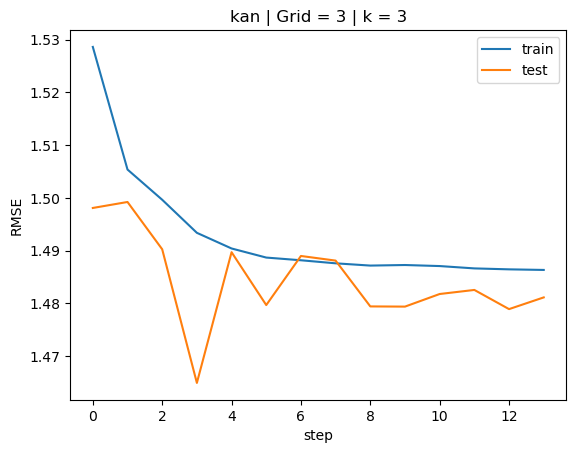

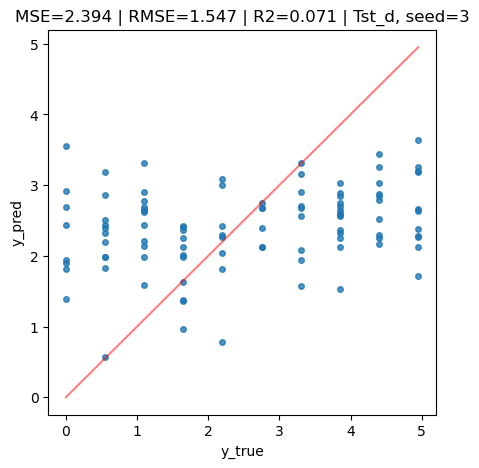

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.57e+00 | e_stop: 10/10 | reg: 8.50e+00 | :  10%| | 10/100 [00:02<


Early stopping criteria raised
saving model version 0.1


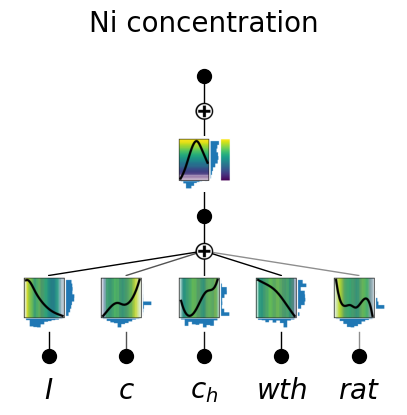

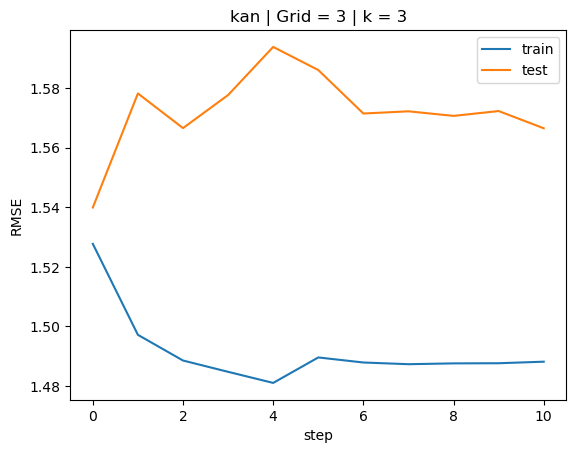

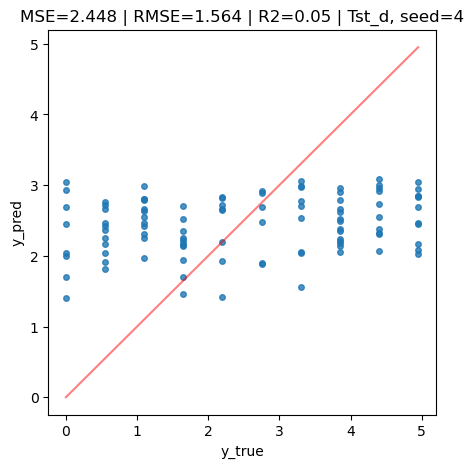

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.51e+00 | e_stop: 10/10 | reg: 7.29e+00 | :  11%| | 11/100 [00:03<


Early stopping criteria raised
saving model version 0.1


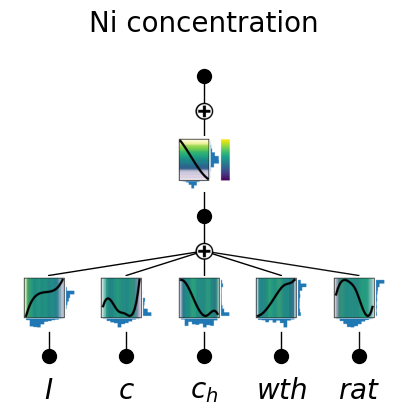

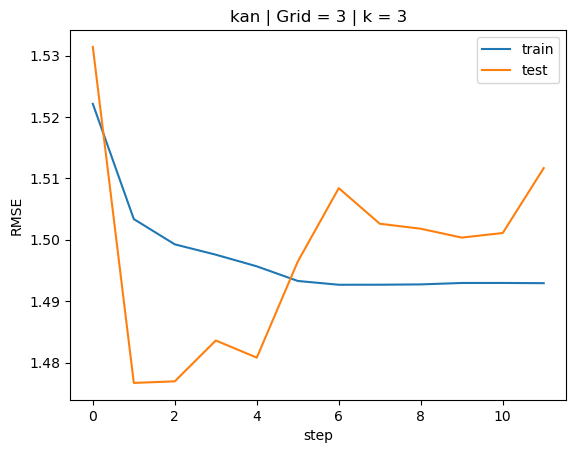

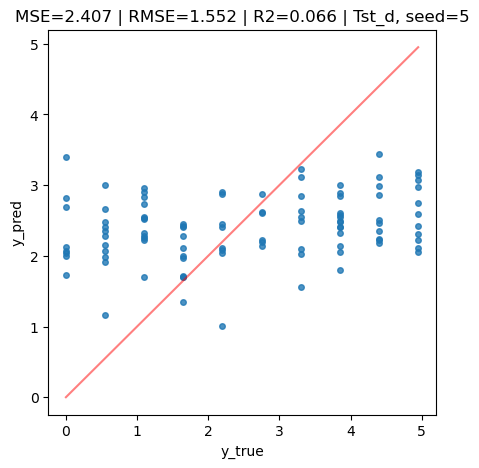

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.46e+00 | e_stop: 10/10 | reg: 9.13e+00 | :  11%| | 11/100 [00:03<


Early stopping criteria raised
saving model version 0.1


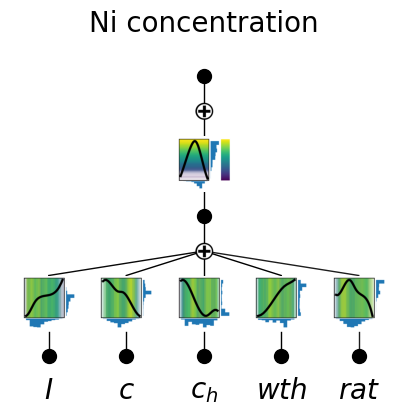

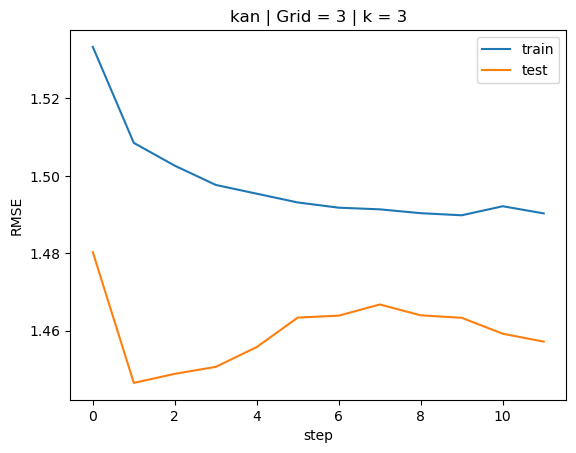

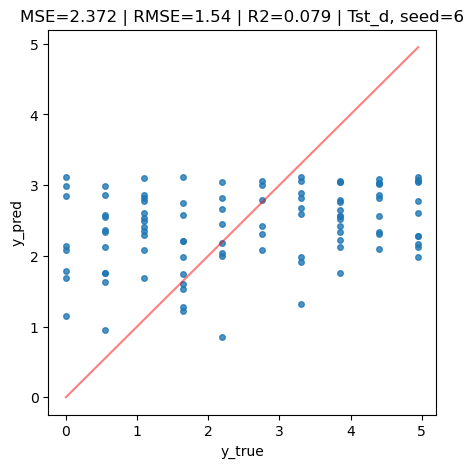

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.50e+00 | e_stop: 10/10 | reg: 6.90e+00 | :  25%|▎| 25/100 [00:06<


Early stopping criteria raised
saving model version 0.1


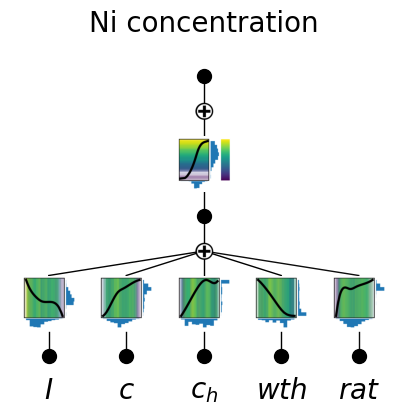

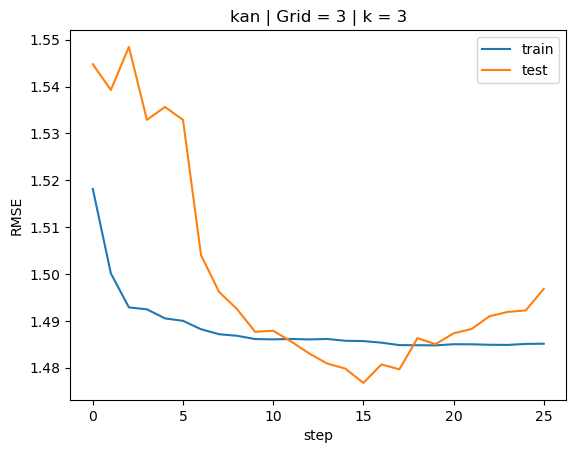

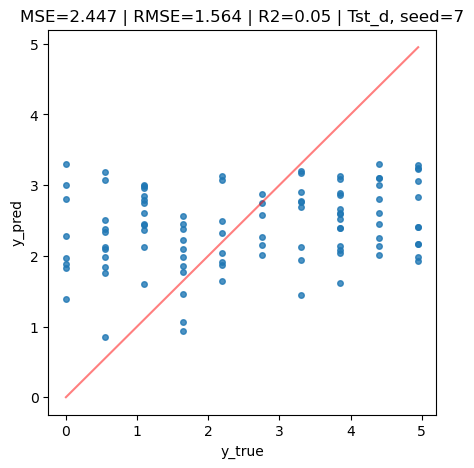

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.50e+00 | tst_loss: 1.54e+00 | e_stop: 10/10 | reg: 6.62e+00 | :  32%|▎| 32/100 [00:07<


Early stopping criteria raised
saving model version 0.1


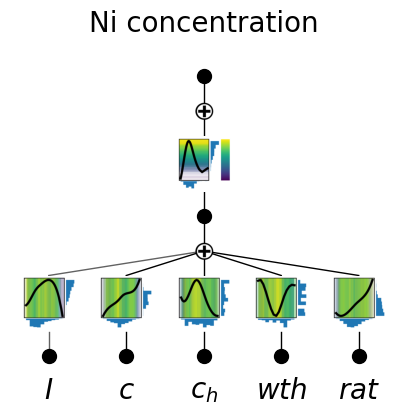

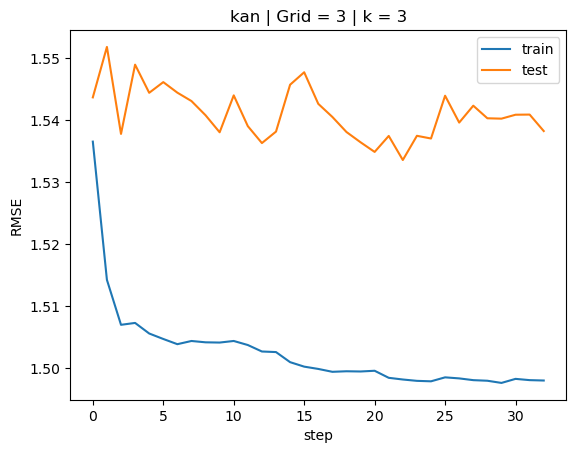

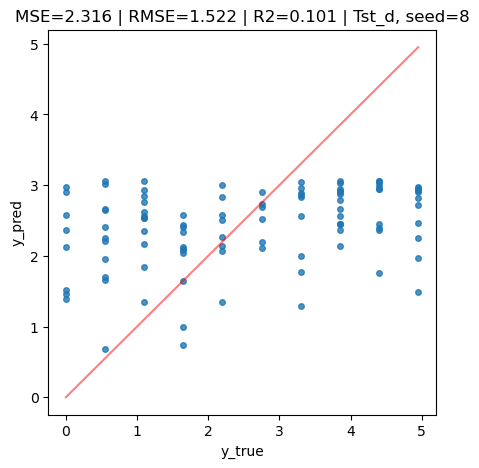

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.47e+00 | tst_loss: 1.62e+00 | e_stop: 10/10 | reg: 8.57e+00 | :  10%| | 10/100 [00:02<


Early stopping criteria raised
saving model version 0.1


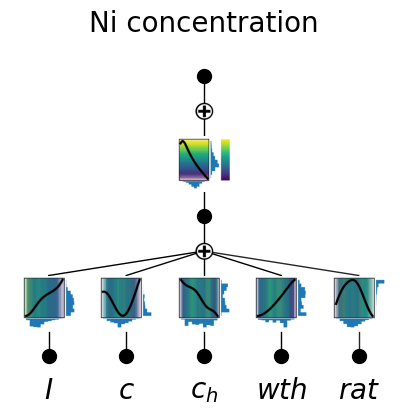

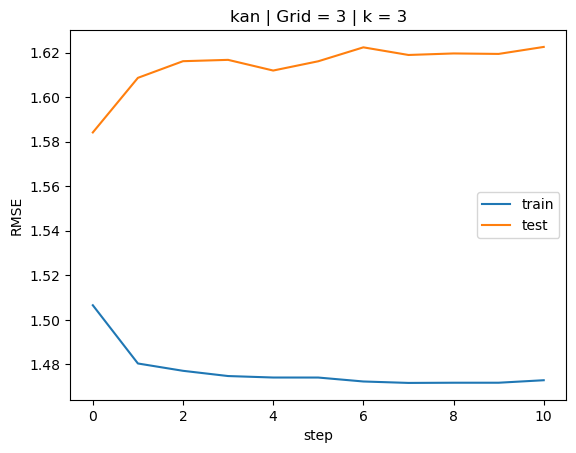

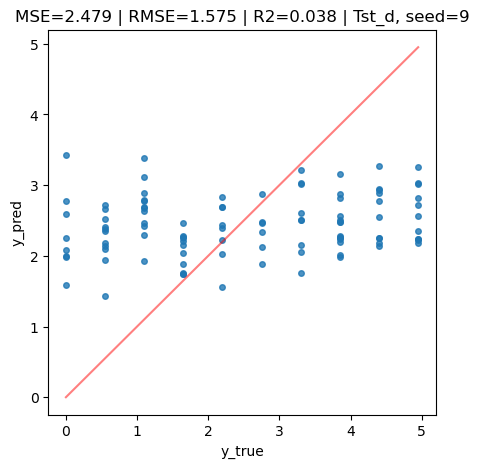

In [19]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=grid, k=k, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.49e+00 | tst_loss: 1.61e+00 | e_stop: 10/10 | reg: 8.50e+00 | :  15%|▏| 15/100 [00:04<


Early stopping criteria raised
saving model version 0.1


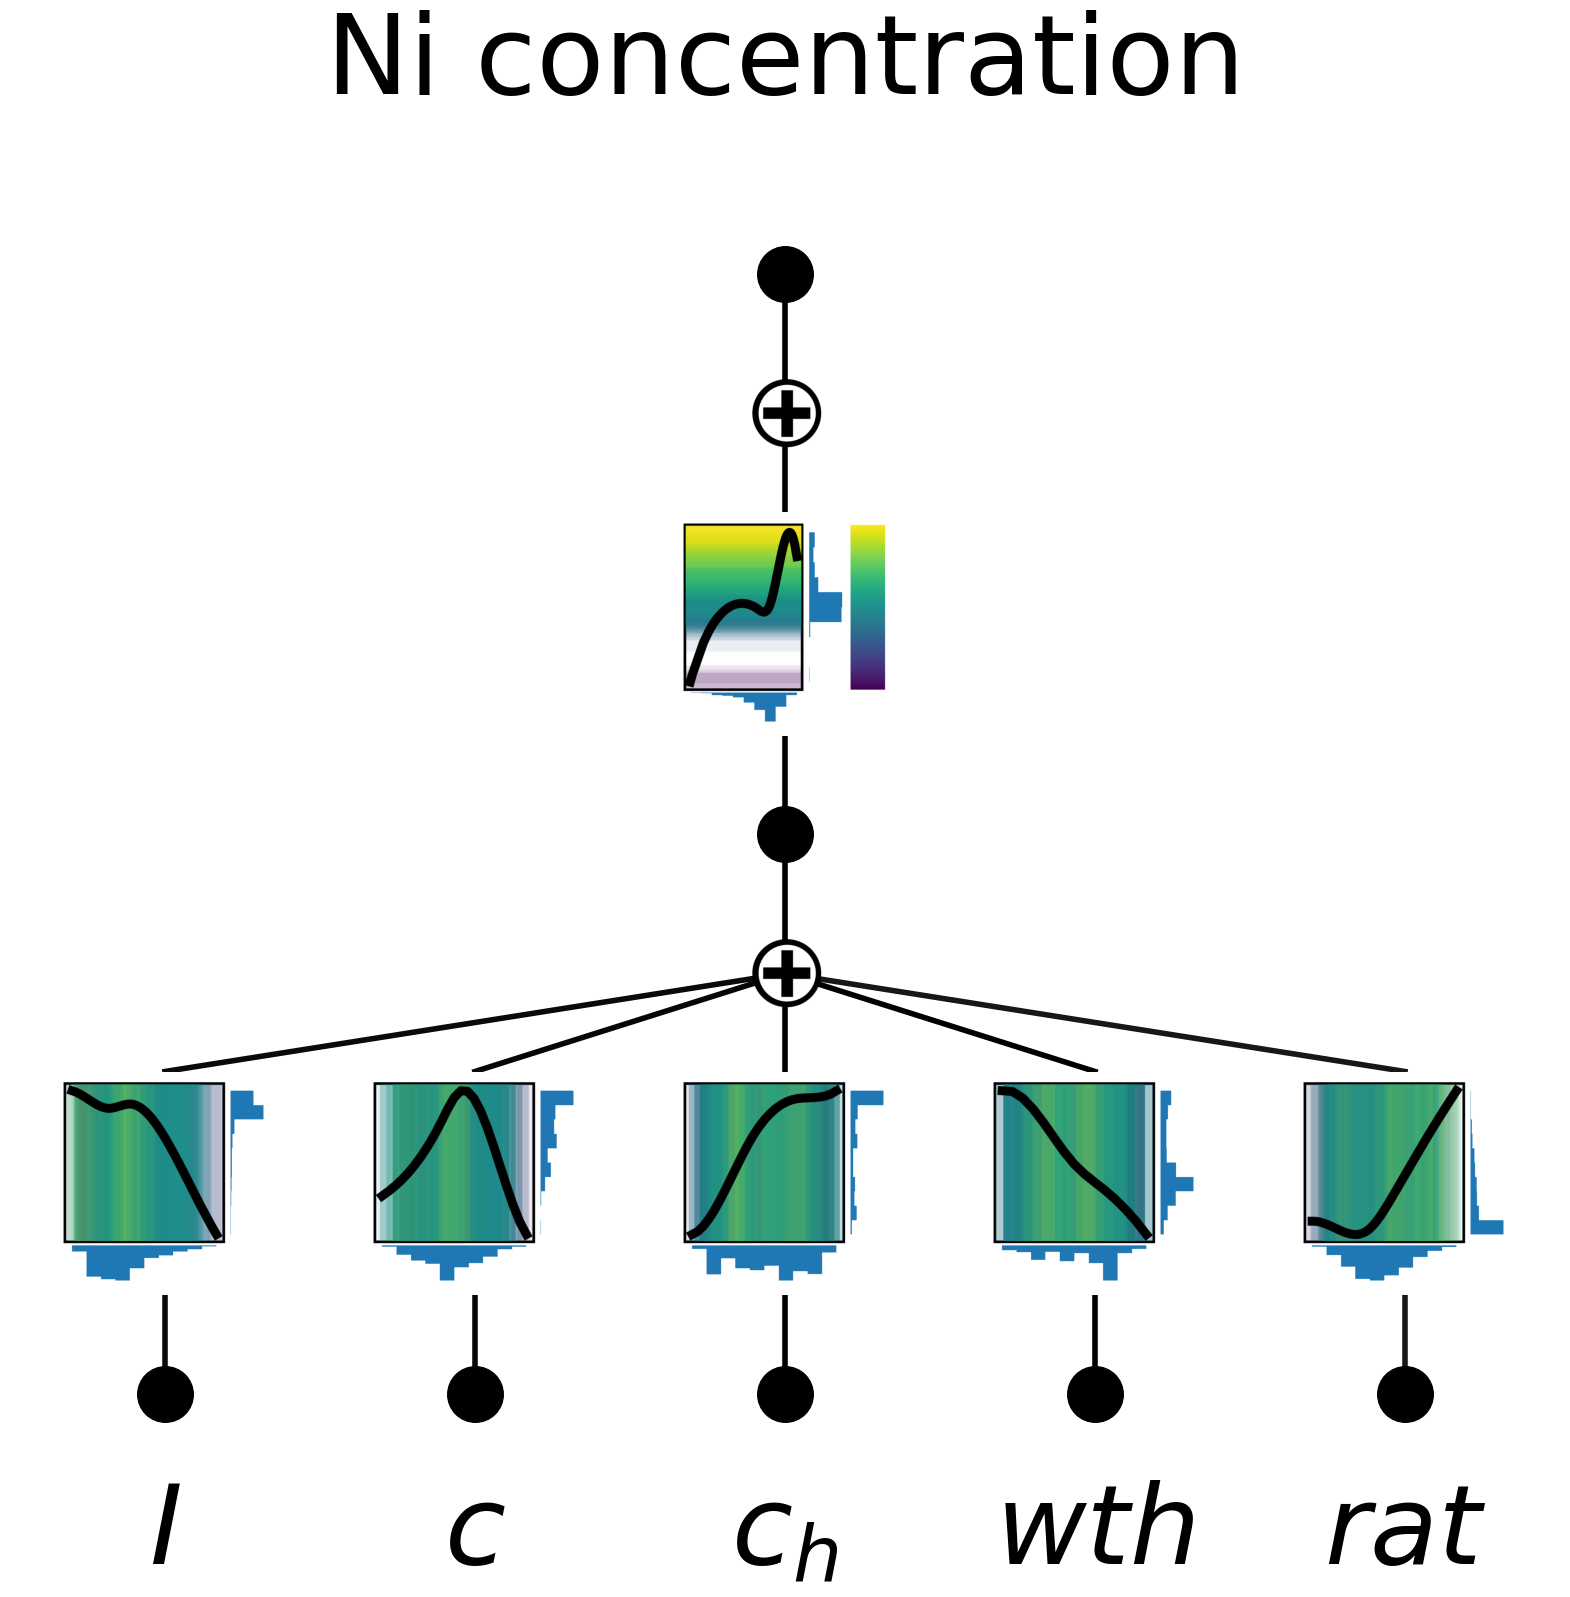

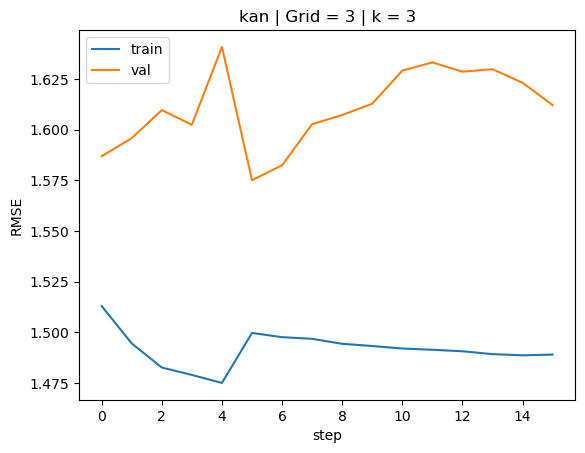

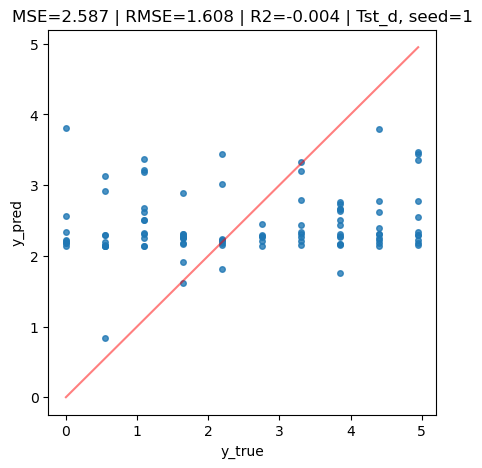

(2.586531971146299, -0.0038294547811463797)

In [20]:
# Choose seed and train again
grid = 3
k = 3

seed = 1
print(f'==========\n- {seed=} -\n==========')
model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 2,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

In [21]:
# suggest activation function
l = 0#1
i = 3#0
j = 0#0

inputs = model2.kan.spline_preacts[l][:,j,i]
outputs = model2.kan.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
#plt.plot(inputs, outputs, marker="o")

model2.kan.suggest_symbolic(l,i,j)

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        x    0.991877 -6.941947           1                1   -0.588389
1        0    0.000000  0.000014           0                0    0.000003
2      cos    0.993049 -7.166495           2                2    0.166701
3      sin    0.993049 -7.166483           2                2    0.166703
4      x^2    0.992917 -7.139316           2                2    0.172137


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9918767213821411,
 1)

In [22]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 3#0
j = 0#0

model2.kan.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2.predict(x_train)

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2


| trn_loss: 1.50e+00 | tst_loss: 1.69e+00 | e_stop: 10/10 | reg: 8.57e+00 | :  12%| | 12/100 [00:04<


Early stopping criteria raised
saving model version 0.3


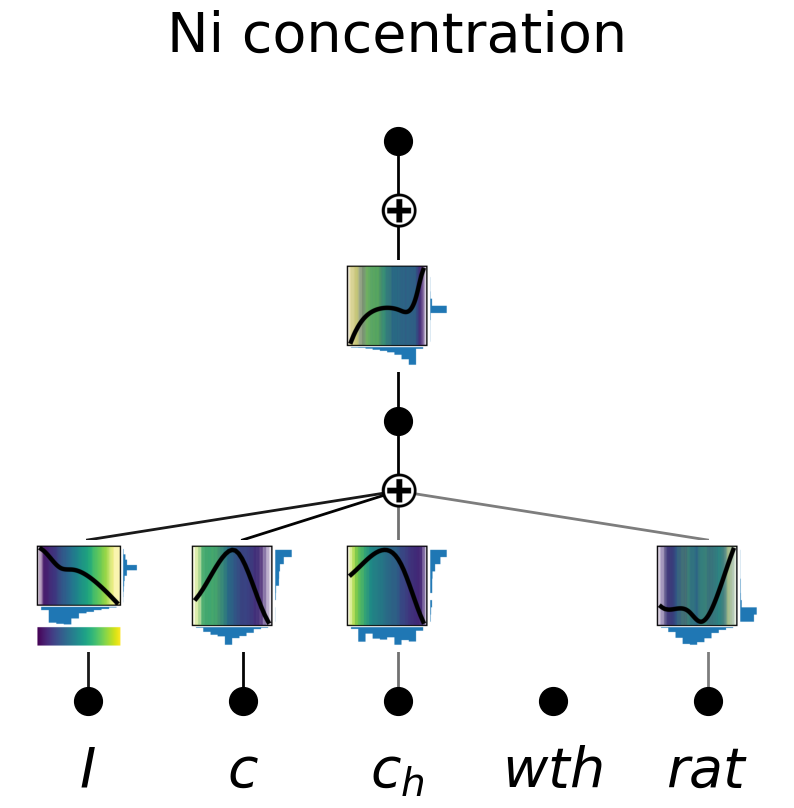

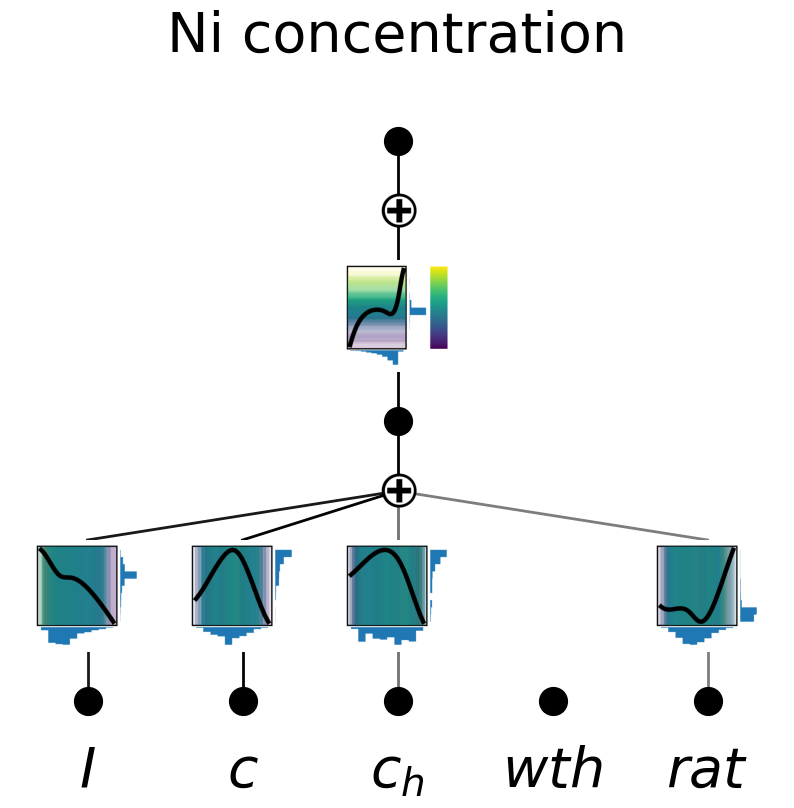

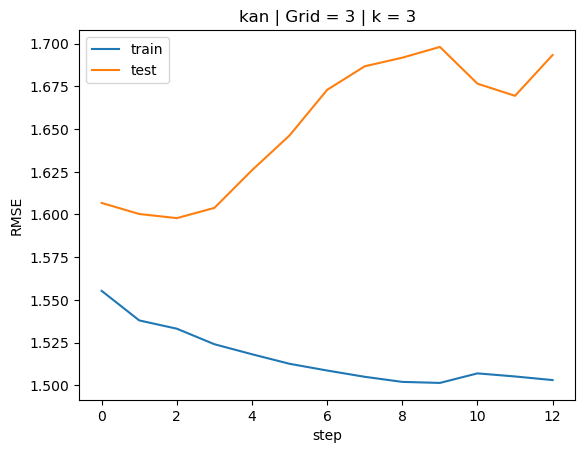

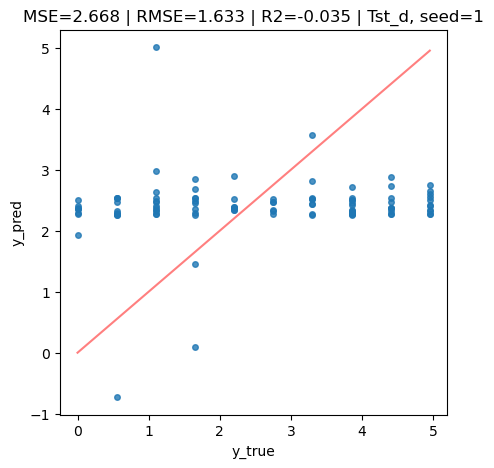

(2.667777890340663, -0.03536088283920624)

In [23]:
# POSTFITTING reduced KAN
# Choose seed and train again
model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 1,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

# $NO_3$

In [24]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['NO3']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


#squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.90e+00 | tst_loss: 2.89e+00 | e_stop: 10/10 | reg: 1.52e+01 | :  25%|▎| 25/100 [00:06<


Early stopping criteria raised
saving model version 0.1


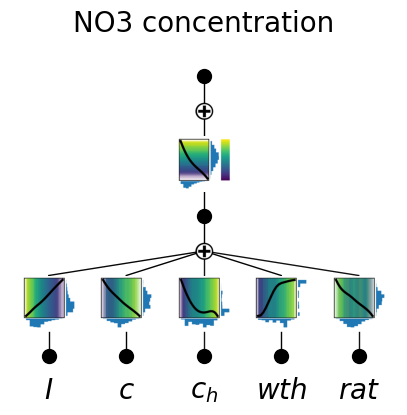

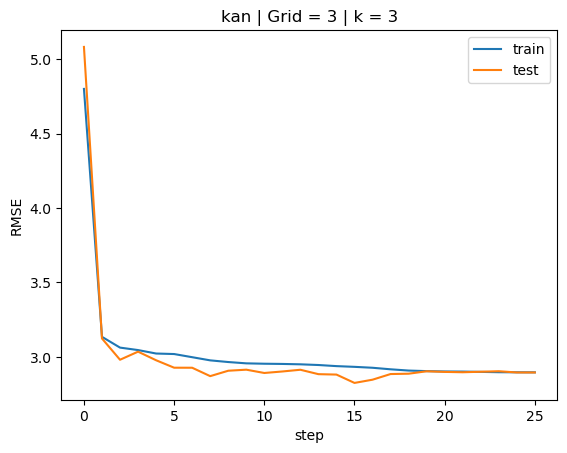

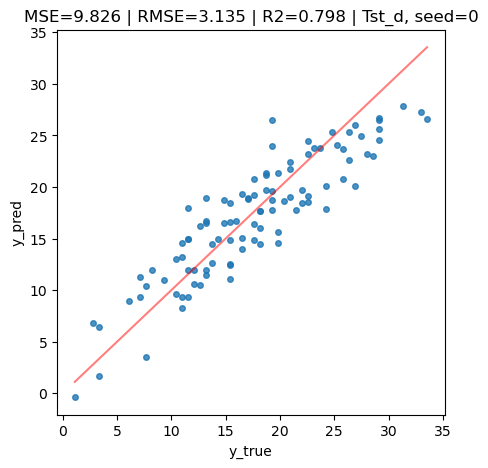

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.86e+00 | tst_loss: 3.10e+00 | e_stop: 10/10 | reg: 1.45e+01 | :  18%|▏| 18/100 [00:04<


Early stopping criteria raised
saving model version 0.1


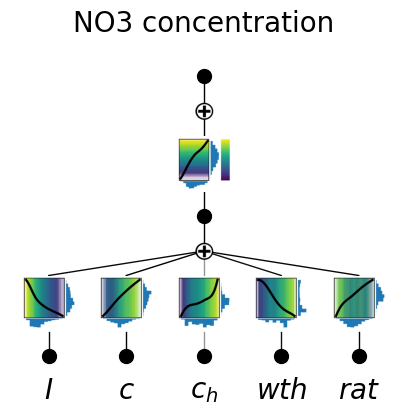

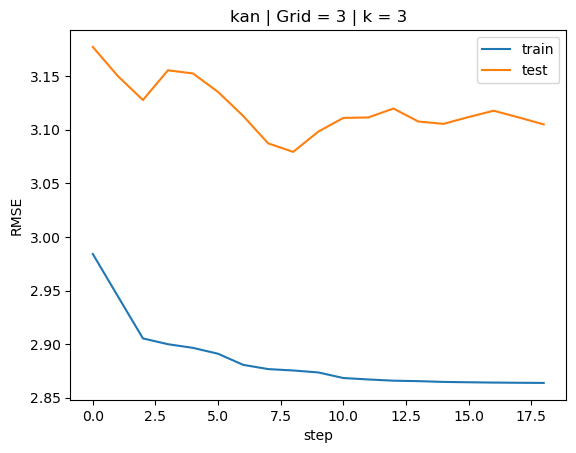

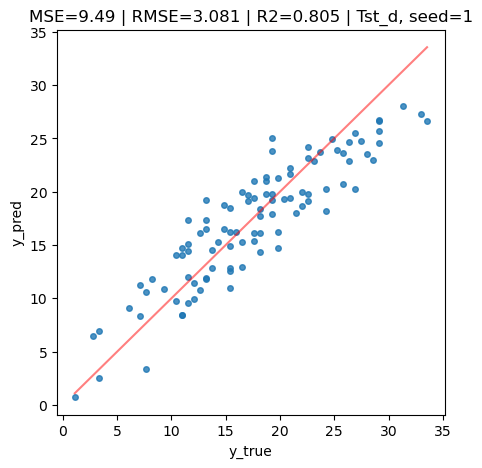

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.90e+00 | tst_loss: 2.93e+00 | e_stop: 10/10 | reg: 1.42e+01 | :  14%|▏| 14/100 [00:03<


Early stopping criteria raised
saving model version 0.1


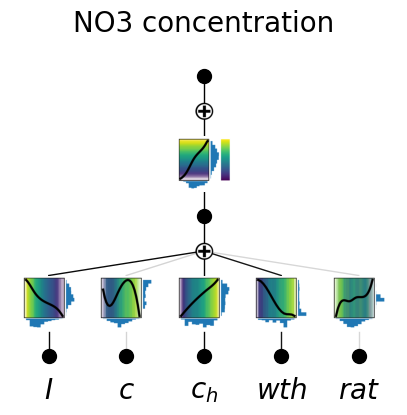

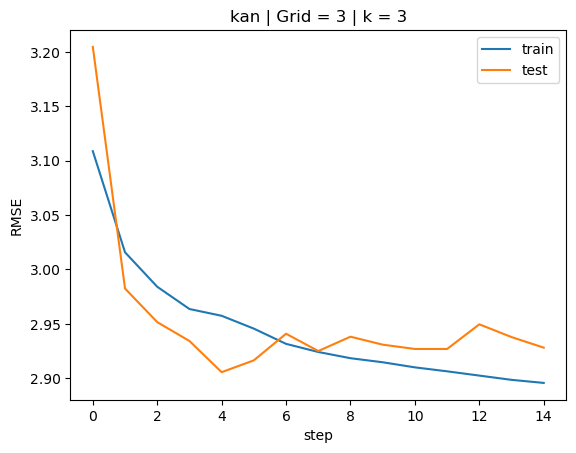

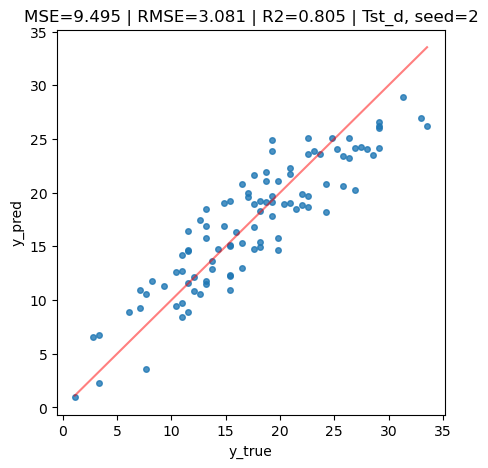

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.93e+00 | tst_loss: 2.92e+00 | e_stop: 10/10 | reg: 1.76e+01 | :  29%|▎| 29/100 [00:07<


Early stopping criteria raised
saving model version 0.1


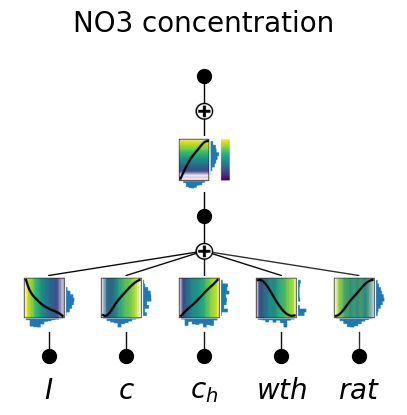

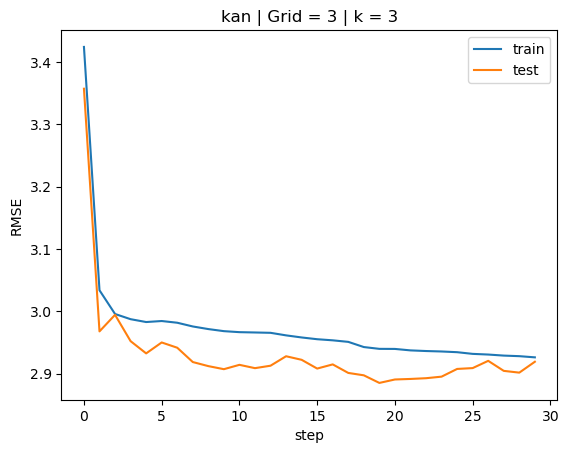

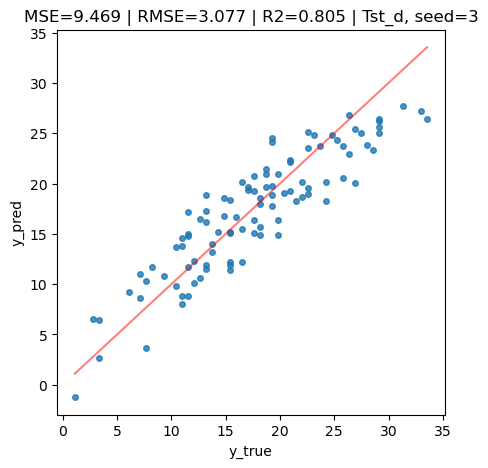

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.90e+00 | tst_loss: 3.03e+00 | e_stop: 10/10 | reg: 1.74e+01 | :  17%|▏| 17/100 [00:04<


Early stopping criteria raised
saving model version 0.1


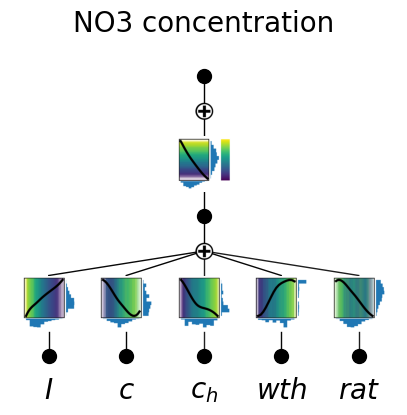

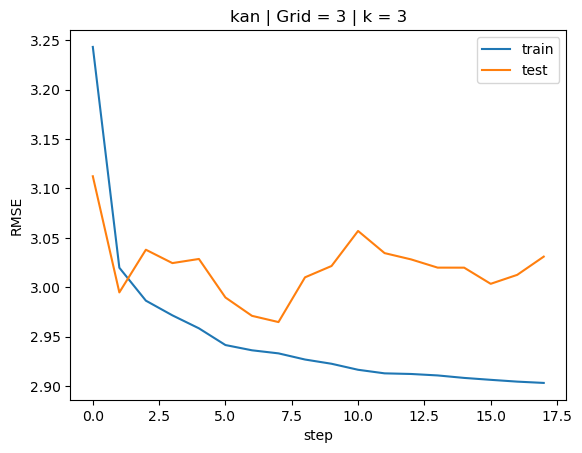

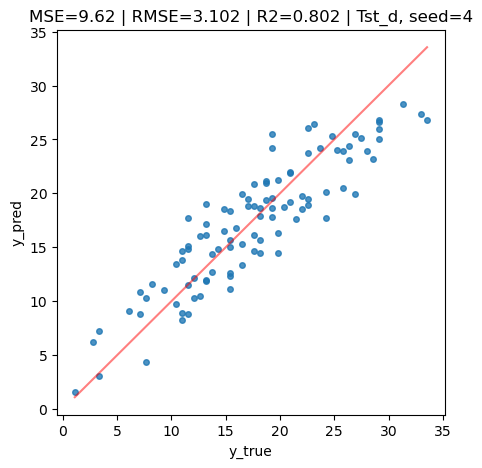

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.96e+00 | tst_loss: 3.04e+00 | e_stop: 10/10 | reg: 1.48e+01 | :  15%|▏| 15/100 [00:03<


Early stopping criteria raised
saving model version 0.1


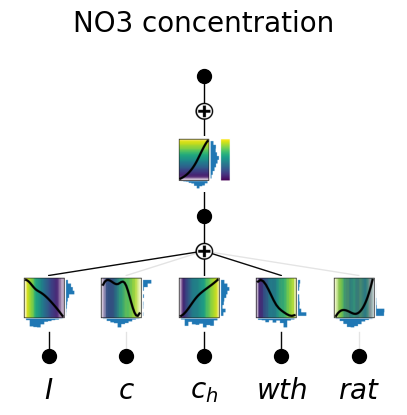

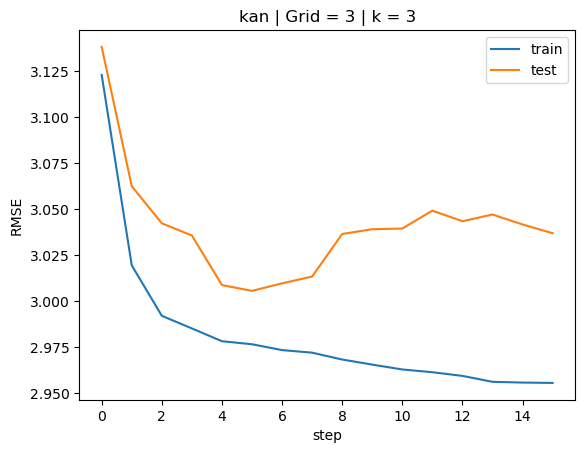

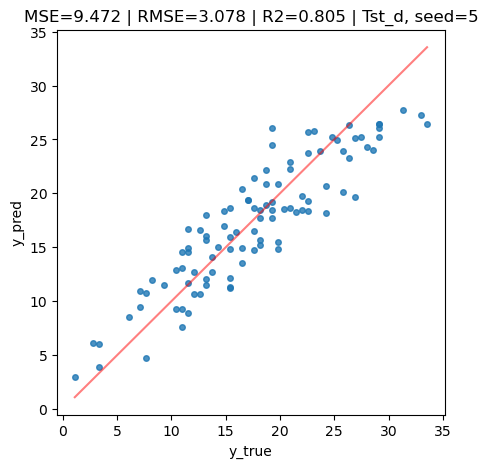

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.96e+00 | tst_loss: 2.98e+00 | e_stop: 10/10 | reg: 2.25e+01 | :  13%|▏| 13/100 [00:03<


Early stopping criteria raised
saving model version 0.1


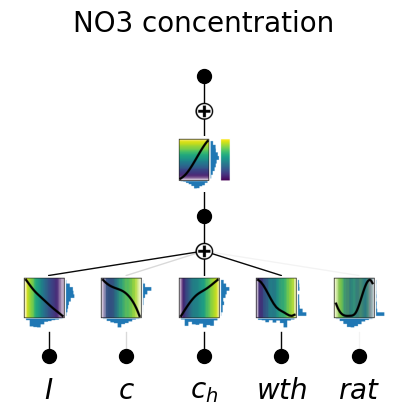

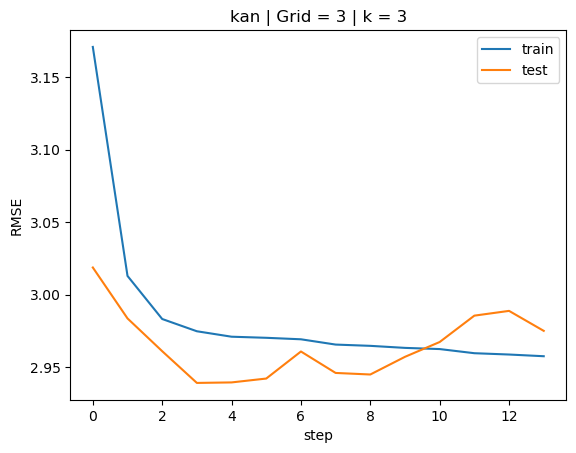

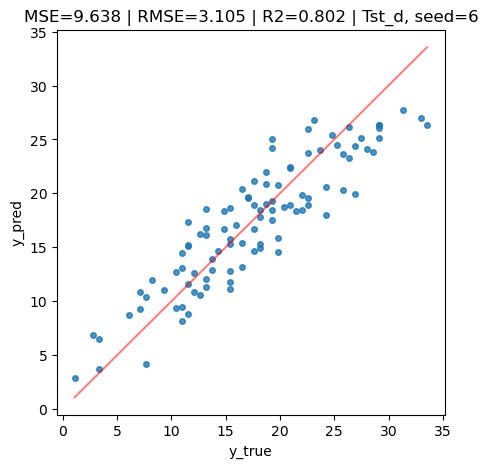

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.90e+00 | tst_loss: 2.81e+00 | e_stop: 10/10 | reg: 1.51e+01 | :  55%|▌| 55/100 [00:12<


Early stopping criteria raised
saving model version 0.1


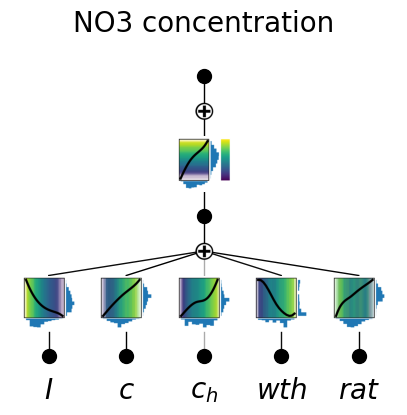

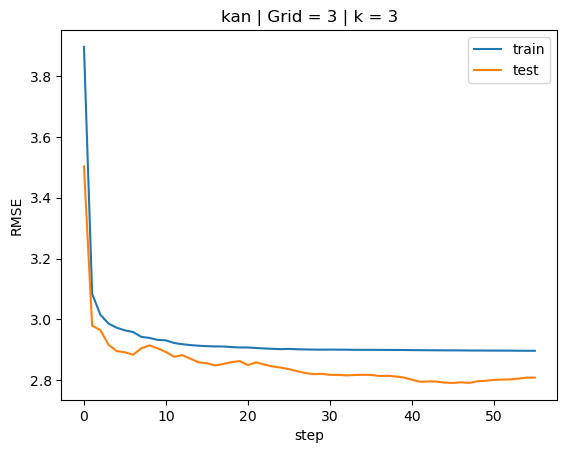

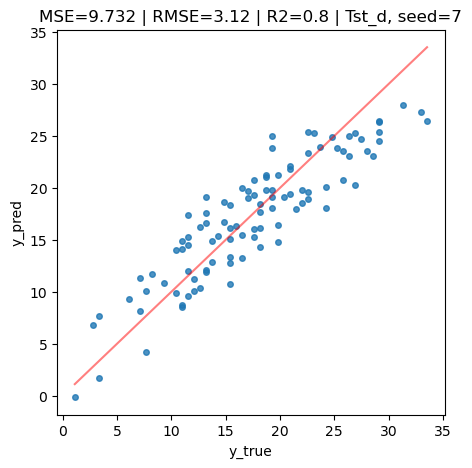

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.93e+00 | tst_loss: 3.00e+00 | e_stop: 10/10 | reg: 2.69e+01 | :  12%| | 12/100 [00:03<


Early stopping criteria raised
saving model version 0.1


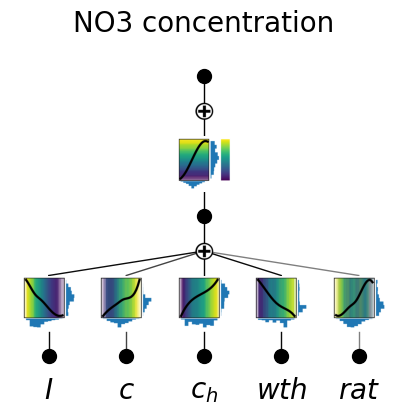

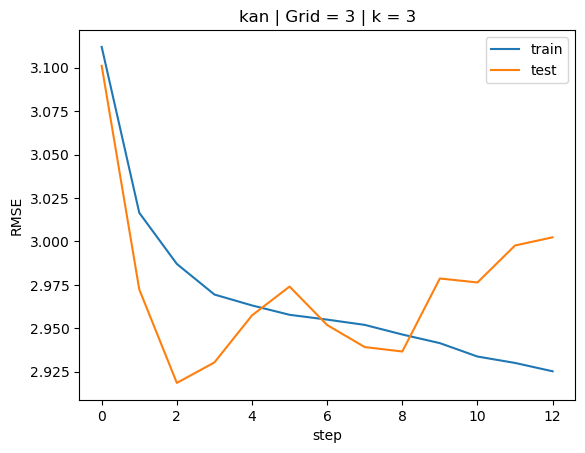

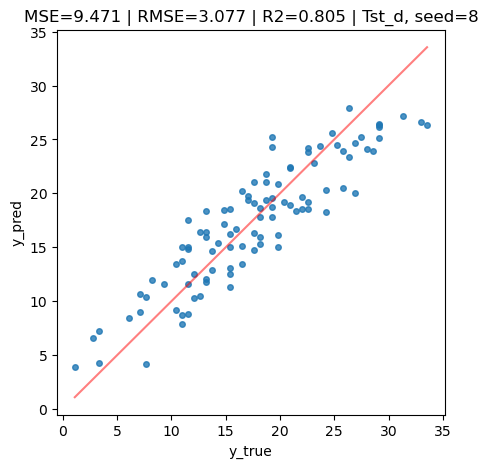

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.84e+00 | tst_loss: 3.34e+00 | e_stop: 10/10 | reg: 1.37e+01 | :  19%|▏| 19/100 [00:04<


Early stopping criteria raised
saving model version 0.1


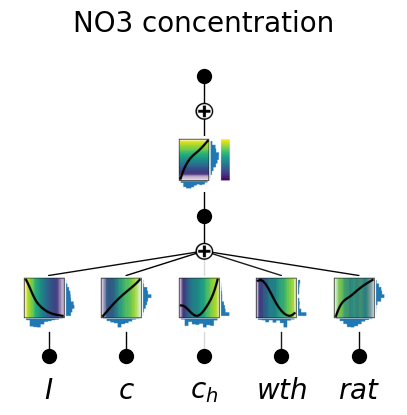

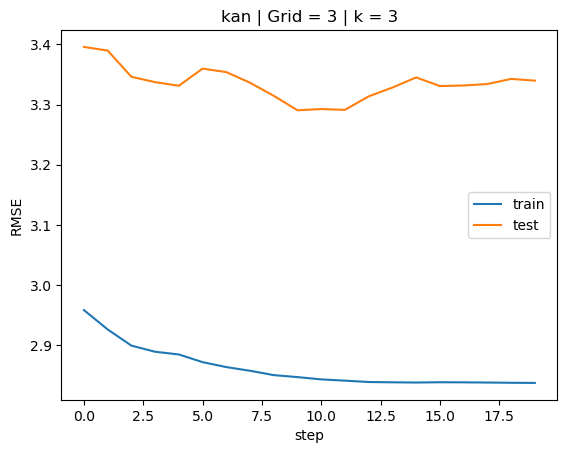

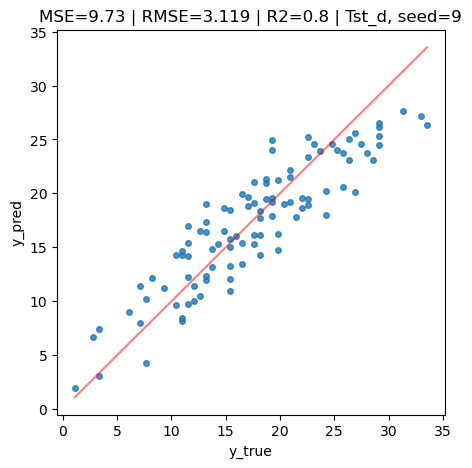

In [25]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=grid, k=k, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| trn_loss: 2.96e+00 | tst_loss: 3.04e+00 | e_stop: 10/10 | reg: 1.48e+01 | :  15%|▏| 15/100 [00:04<


Early stopping criteria raised
saving model version 0.1


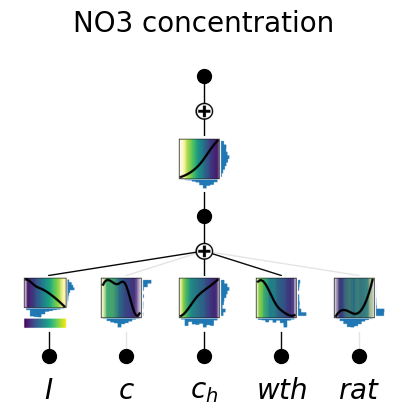

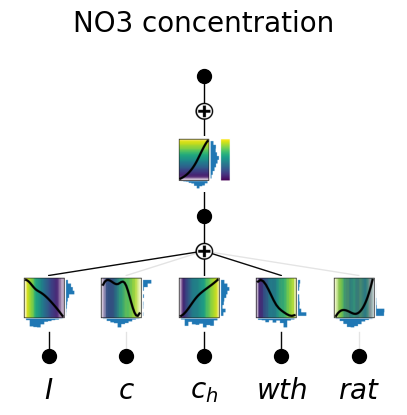

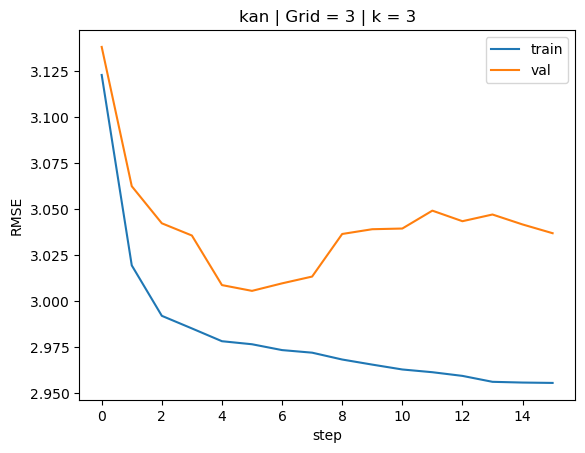

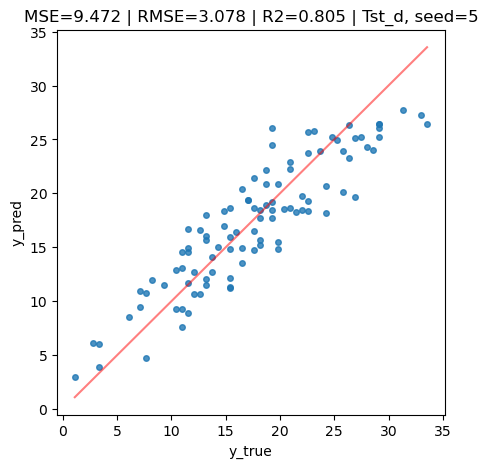

(9.472426845477708, 0.8050922089084915)

In [26]:
# Choose seed and train again
seed = 5
print(f'==========\n- {seed=} -\n==========')
model2 = KANRegressor(hidden_layer_sizes=[1,], seed=seed, grid=3, k=3, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

In [27]:
# suggest activation function
l = 0#1
i = 3#0
j = 0#0

inputs = model2.kan.spline_preacts[l][:,j,i]
outputs = model2.kan.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
#plt.plot(inputs, outputs, marker="o")

model2.kan.suggest_symbolic(l,i,j)

   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0         x    0.946201 -4.215998           1                1   -0.043200
1         0    0.000000  0.000014           0                0    0.000003
2       cos    0.993394 -7.239738           2                2    0.152052
3       sin    0.993393 -7.239608           2                2    0.152078
4  gaussian    0.998890 -9.801803           3                3    0.439639


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9462006092071533,
 1)

In [28]:
# SET ACTIVATION FUNCTION TO 0
l = 0#1
i = 1#0
j = 0#0

model2.kan.fix_symbolic(l,i,j,'0',fit_params_bool=True)
_ = model2.predict(x_train)

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2


| trn_loss: 2.95e+00 | tst_loss: 3.03e+00 | e_stop: 10/10 | reg: 1.82e+01 | :  10%| | 10/100 [00:03<


Early stopping criteria raised
saving model version 0.3


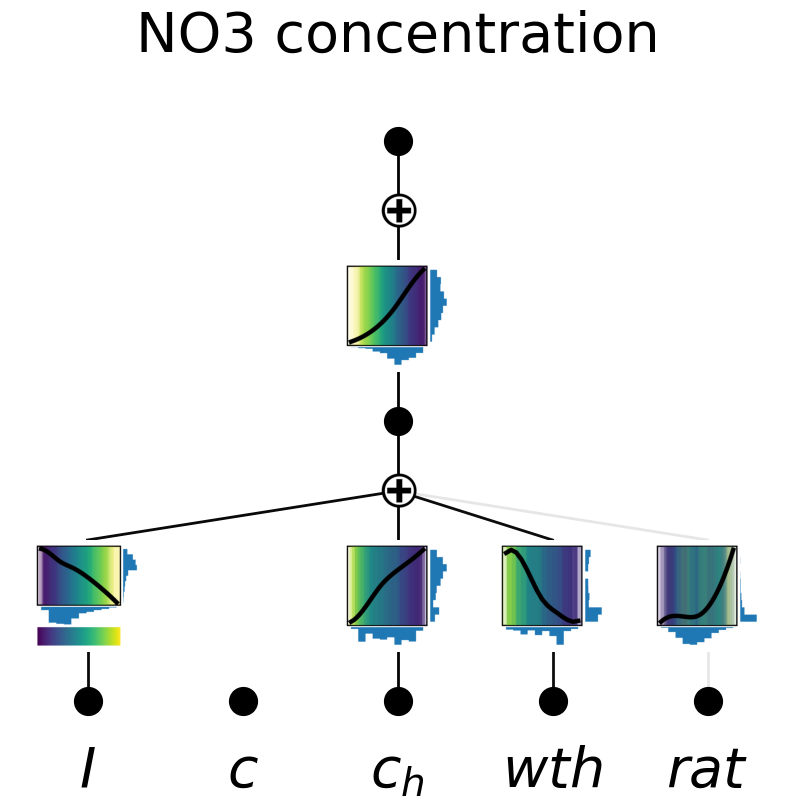

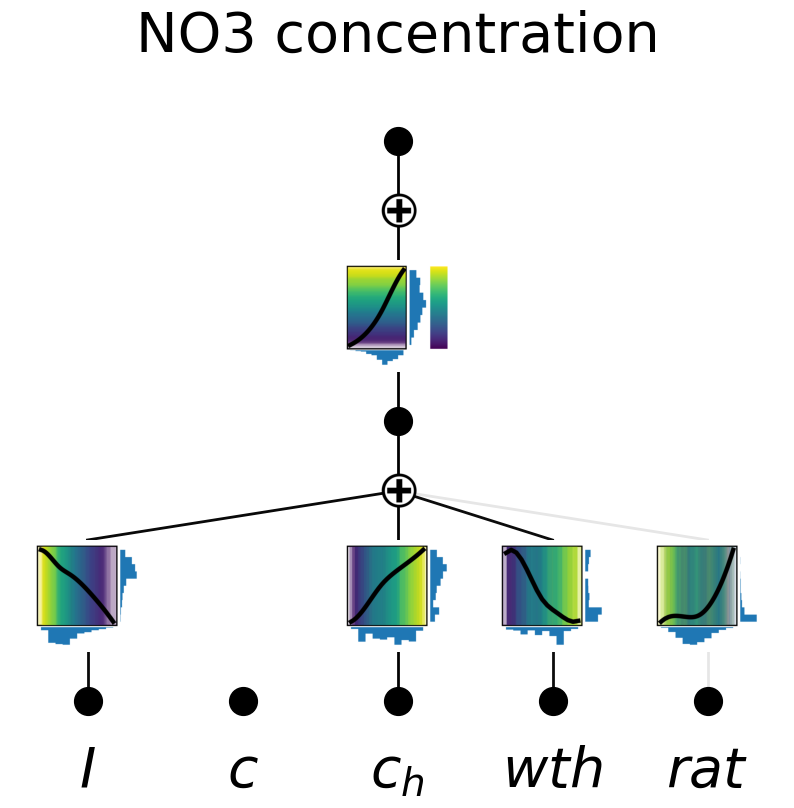

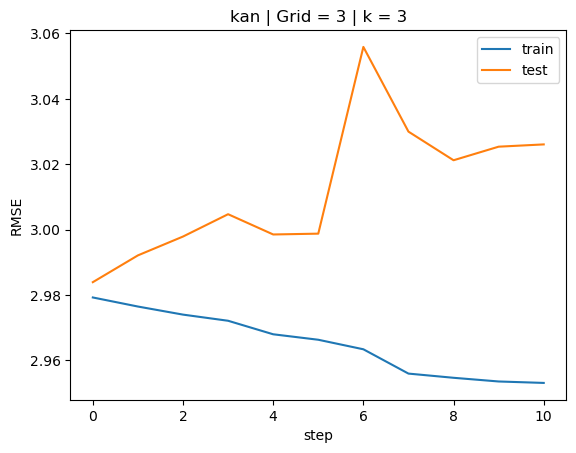

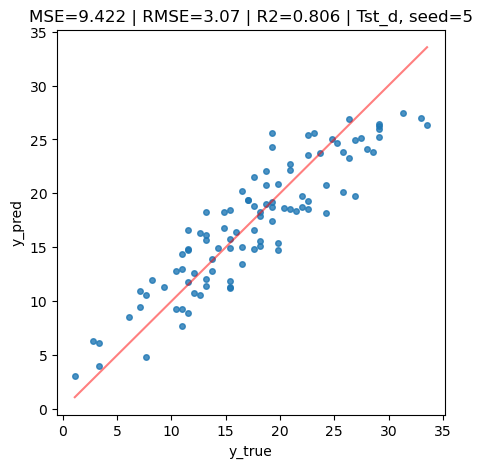

(9.422291748168906, 0.8061238052704398)

In [29]:
# POSTFITTING reduced KAN
# Choose seed and train again
model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_IONS[0] + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 1,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")